In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
# %matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

from plotting import *
plt.style.use('dark_background')
from tqdm.notebook import trange, tqdm

%matplotlib notebook

In [2]:

parser = argparse.ArgumentParser()
parser.add_argument('-e','--epochs', type=int, default=25)
parser.add_argument('-cmap','--coordinateMapping', type=str, default='preserving')
parser.add_argument('-w','--windowFunction', type=str, default='poly6')
parser.add_argument('-c','--cutoff', type=int, default=1800)
parser.add_argument('-b','--batch_size', type=int, default=2)
parser.add_argument('--cutlassBatchSize', type=int, default=512)
parser.add_argument('-r','--lr', type=float, default=0.01)
parser.add_argument('--lr_decay_factor', type=float, default=0.9)
parser.add_argument('--lr_decay_step_size', type=int, default=1)
parser.add_argument('--weight_decay', type=float, default=0)
parser.add_argument('-x','--rbf_x', type=str, default='linear')
parser.add_argument('-y','--rbf_y', type=str, default='linear')
parser.add_argument('-n','--n', type=int, default=4)
parser.add_argument('-m','--m', type=int, default=4)
parser.add_argument('--seed', type=int, default=42)
parser.add_argument('--networkseed', type=int, default=42)
parser.add_argument('-d','--frameDistance', type=int, default=1)
parser.add_argument('--dataDistance', type=int, default=1)
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--gpus', type=int, default=1)
parser.add_argument('-f','--forwardLoss', type=bool, default=False)
parser.add_argument('-v','--verbose', type=bool, default=False)
parser.add_argument('-l','--li', type=bool, default=True)
parser.add_argument('-a','--activation', type=str, default='relu')
parser.add_argument('--arch', type=str, default='32 64 64 3')
parser.add_argument('--limitData', type=int, default=-1)
parser.add_argument('--iterations', type=int, default=1000)
parser.add_argument('-u', '--maxUnroll', type=int, default=10)
parser.add_argument('--minUnroll', type=int, default=2)
parser.add_argument('-augj', '--augmentJitter', type=bool, default=True)
parser.add_argument('-j', '--jitterAmount', type=float, default=0.01)
parser.add_argument('-augr', '--augmentAngle', type=bool, default=True)
parser.add_argument('-adjust', '--adjustForFrameDistance', type = bool, default = True)
parser.add_argument('-netArch', '--network', type=str, default='default')
parser.add_argument('-norm', '--normalized', type=bool, default=False)

_StoreAction(option_strings=['-norm', '--normalized'], dest='normalized', nargs=None, const=None, default=False, type=<class 'bool'>, choices=None, required=False, help=None, metavar=None)

In [3]:
import shlex

In [4]:
a = "--verbose TRUE --frameDistance 16 -n 4 -m 4 --arch '32 64 64 3' -x 'rbf cubic_spline' -y 'rbf cubic_spline' -w None -cmap cartesian --epochs 25 --networkseed 3 -netArch default"
a = shlex.split(a)
args = parser.parse_args(a)

In [5]:

if args.verbose:
    print('Setting all rng seeds to %d' % args.seed)
import random 
import numpy as np

random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)

if args.verbose:
    print('Available cuda devices:', torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if args.verbose:
    print('Running on Device %s' % device)
torch.set_num_threads(1)

# from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from datautils import *
from plotting import *

# Use dark theme
plt.style.use('dark_background')
from tqdm import tqdm
import os

from rbfNet import *
from tqdm.notebook import trange, tqdm


if args.verbose:
    print('Parsing data in ../export')
basePath = '../export'
basePath = os.path.expanduser('/mnt/data/datasets/generative2D')
# basePath = os.path.expanduser('~/dev/datasets/generative2D')

Setting all rng seeds to 42
Available cuda devices: 1
Running on Device cuda
Parsing data in ../export


In [6]:
def particleAnalysis(positions, gtPositions, boundaryPositions, velocities, gtVelocities, fluidArea, boundaryArea, attributes, plot = True):
    positionLoss, velocityLoss, density, gtDensity, colorField, gtColorField, colorGrad, gtColorGrad = analyzeParticles(positions, gtPositions, boundaryPositions, velocities, gtVelocities, fluidArea, boundaryArea, attributes)
    if plot:
        fig, axis = plt.subplots(3, 6, figsize=(12,8*1.09), sharex = False, sharey = False, squeeze = False)

        scatterPlot(axis[0,0], positions, positionLoss, boundaryPositions, 'Position Loss')
        scatterPlot(axis[0,1], positions, velocityLoss, boundaryPositions, 'Velocity Loss')
        scatterPlot(axis[0,2], positions, density, boundaryPositions, 'Density')
        scatterPlot(axis[0,3], positions, colorField, boundaryPositions, 'Color')
        scatterPlot(axis[0,4], positions, colorGrad[:,0], boundaryPositions, 'Grad.x Color')
        scatterPlot(axis[0,5], positions, colorGrad[:,1], boundaryPositions, 'Grad.y Color')

        scatterPlot(axis[1,0], gtPositions, torch.zeros_like(density), boundaryPositions, 'GT Position Loss')
        scatterPlot(axis[1,1], gtPositions, torch.zeros_like(density), boundaryPositions, 'GT Velocity Loss')
        scatterPlot(axis[1,2], gtPositions, gtDensity, boundaryPositions, 'GT Density')
        scatterPlot(axis[1,3], gtPositions, gtColorField, boundaryPositions, 'GT Color')
        scatterPlot(axis[1,4], gtPositions, gtColorGrad[:,0], boundaryPositions, 'GT Grad.x Color')
        scatterPlot(axis[1,5], gtPositions, gtColorGrad[:,1], boundaryPositions, 'GT Grad.y Color')

        scatterPlot(axis[2,0], gtPositions, positionLoss, boundaryPositions, 'Position Loss')
        scatterPlot(axis[2,1], gtPositions, velocityLoss, boundaryPositions, 'Velocity Loss')
        scatterPlot(axis[2,2], gtPositions, density - gtDensity, boundaryPositions, 'Diff Density')
        scatterPlot(axis[2,3], gtPositions, colorField - gtColorField, boundaryPositions, 'Diff Color')
        scatterPlot(axis[2,4], gtPositions, colorGrad[:,0] - gtColorGrad[:,0], boundaryPositions, 'Diff Grad.x Color')
        scatterPlot(axis[2,5], gtPositions, colorGrad[:,1] - gtColorGrad[:,1], boundaryPositions, 'Diff Grad.y Color')

        fig.tight_layout()
    return positionLoss, velocityLoss, density, gtDensity, colorField, gtColorField, colorGrad, gtColorGrad
import scipy.stats as stats

def getPSD(data):
    image = data.detach().cpu().numpy()
    npix = image.shape[0]
    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)**2
    kfreq = np.fft.fftfreq(npix) * npix

    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()
    kbins = np.arange(0.01, npix//(2*np.pi)+1, 0.5)
    kbins = np.arange(0.5, npix//2+1, 1.)

    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                         statistic = "mean",
                                         bins = kbins)

    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return kvals, Abins

def analyzeMesh(data, filterLevels = 0):
# data = torch.linalg.norm(meshVelocity,dim=1).reshape(xx.shape)
    if filterLevels > 0 :
        filtered = scipy.ndimage.gaussian_filter(data.detach().cpu().numpy(),filterLevels)
        filtered = torch.tensor(filtered, device = data.device, dtype = data.dtype)
    else:
        filtered = data
    # data = torch.linalg.norm(meshVelocity,dim=1)
    fft = torch.fft.fftshift(torch.fft.fft2(filtered))
    # fft = torch.fft.fft2(torch.linalg.norm(meshVelocity,dim=1).reshape(xx.shape))
    fftfreq = torch.fft.fftshift(torch.fft.fftfreq(filtered.shape[0],2 / filtered.shape[0]))
    # fftfreq = (torch.fft.fftfreq(xx.shape[0],2 / xx.shape[0]))
    fx, ft = torch.meshgrid(fftfreq, fftfreq, indexing = 'xy')
    # print(fx.shape)
    # print(ft.shape)
    fp = torch.vstack((fx.flatten(),ft.flatten())).mT

    return fp, fft, getPSD(filtered), filtered

def meshAnalysis(positions, data, gtData,plot = True, linThresh = 1e-2, linScale = 1):
    fp, fft, psd, filtered = analyzeMesh(data)
    fp, gtFft, gtPsd, gtFiltered = analyzeMesh(gtData)
    if plot:
        fig, axis = plt.subplots(3, 4, figsize=(16,11*1.09), sharex = False, sharey = False, squeeze = False)
        meshPlot(axis[0,0], positions, data, 'Original Prediction')
        meshPlot(axis[0,1], positions, filtered, 'Filtered Prediction')
        ax = axis[0,2]
        ax.axis('equal')
        ax.set_title('FFT Prediction')
        im = ax.pcolormesh(fp[:,0].reshape(data.shape).detach().cpu().numpy(), fp[:,1].reshape(data.shape).detach().cpu().numpy(), torch.real(fft).reshape(data.shape).detach().cpu().numpy(),
                          norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-torch.max(torch.abs(torch.real(fft))), vmax=torch.max(torch.abs(torch.real(fft))), base=10), cmap = 'twilight')    
        ax.set_xscale('symlog', linthresh=linThresh, linscale = linScale, subs = [1, 2, 3, 4, 5, 6, 7, 8, 9])  
        ax.set_yscale('symlog', linthresh=linThresh, linscale = linScale, subs = [1, 2, 3, 4, 5, 6, 7, 8, 9])
        ax1_divider = make_axes_locatable(ax)
        cax1 = ax1_divider.append_axes("bottom", size="5%", pad="15%")
        GTcbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
        GTcbar.ax.tick_params(labelsize=8) 
        kvals,Abins = psd
        axis[0,3].set_title('PSD Prediction')
        axis[0,3].loglog(kvals, Abins)
        axis[0,3].set_xlabel("$k$")
        axis[0,3].set_ylabel("$P(k)$")
        # axis[0,0].legend()

        meshPlot(axis[1,0], positions, gtData, 'Original Groundtruth')
        meshPlot(axis[1,1], positions, gtFiltered, 'Filtered Groundtruth')
        ax = axis[1,2]
        ax.axis('equal')
        ax.set_title('FFT Groundtruth')
        im = ax.pcolormesh(fp[:,0].reshape(data.shape).detach().cpu().numpy(), fp[:,1].reshape(data.shape).detach().cpu().numpy(), torch.real(gtFft).reshape(data.shape).detach().cpu().numpy(),
                          norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-torch.max(torch.abs(torch.real(gtFft))), vmax=torch.max(torch.abs(torch.real(gtFft))), base=10), cmap = 'twilight')     
        ax.set_xscale('symlog', linthresh=linThresh, linscale = linScale, subs = [1, 2, 3, 4, 5, 6, 7, 8, 9])  
        ax.set_yscale('symlog', linthresh=linThresh, linscale = linScale, subs = [1, 2, 3, 4, 5, 6, 7, 8, 9])
        ax1_divider = make_axes_locatable(ax)
        cax1 = ax1_divider.append_axes("bottom", size="5%", pad="15%")
        GTcbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
        GTcbar.ax.tick_params(labelsize=8) 
        kvals,Abins = gtPsd
        axis[1,3].set_title('PSD Groundtruth')
        axis[1,3].loglog(kvals, Abins)
        axis[1,3].set_xlabel("$k$")
        axis[1,3].set_ylabel("$P(k)$")

        meshPlot(axis[2,0], positions, data - gtData, 'Original Difference')
        meshPlot(axis[2,1], positions, filtered - gtFiltered, 'Filtered Difference')
        ax = axis[2,2]
        ax.axis('equal')
        ax.set_title('FFT Difference')
        diff = (torch.real(fft) - torch.real(gtFft))
        im = ax.pcolormesh(fp[:,0].reshape(data.shape).detach().cpu().numpy(), fp[:,1].reshape(data.shape).detach().cpu().numpy(), diff.reshape(data.shape).detach().cpu().numpy(),
                          norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-torch.max(torch.abs(diff)), vmax=torch.max(torch.abs(diff)), base=10), cmap = 'twilight')     
        ax.set_xscale('symlog', linthresh=linThresh, linscale = linScale, subs = [1, 2, 3, 4, 5, 6, 7, 8, 9])  
        ax.set_yscale('symlog', linthresh=linThresh, linscale = linScale, subs = [1, 2, 3, 4, 5, 6, 7, 8, 9])
        ax1_divider = make_axes_locatable(ax)
        cax1 = ax1_divider.append_axes("bottom", size="5%", pad="15%")
        GTcbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
        GTcbar.ax.tick_params(labelsize=8) 
        kvals,Abins = gtPsd
        axis[2,3].set_title('PSD')
        axis[2,3].loglog(kvals, Abins,label = 'GT')
        kvals,Abins = psd
        axis[2,3].loglog(kvals, Abins,label = 'pred')
        axis[2,3].set_xlabel("$k$")
        axis[2,3].set_ylabel("$P(k)$")
        axis[2,3].legend()

        fig.tight_layout()
    
    return fp, fft, gtFft, psd, gtPsd

def getMeshQuantities(xFluid, bPositions, area, boundaryArea, density, velocity, attributes, n = 512, supportScale = 1):
    x = torch.linspace(-1,1,n, device = xFluid.device, dtype = xFluid.dtype)
    y = torch.linspace(-1,1,n, device = xFluid.device, dtype = xFluid.dtype)
    xx,yy = torch.meshgrid(x,y, indexing='xy')

    xxf = xx.flatten()
    yyf = yy.flatten()
    positions = torch.vstack((xxf, yyf)).mT
    z = yyf
    # z = torch.linalg.norm(positions,dim=1).reshape(xx.shape)
#     bPositions = boundaryPositions.to(device)
#     area = inputData['fluidArea'].to(device)
#     boundaryArea = inputData['boundaryArea'].to(device)

    xm, xf = radius(xFluid, positions, attributes['support'] * supportScale, max_num_neighbors = 256, batch_x = None, batch_y = None)


    # fluidNeighbors = torch.stack([xf, xm], dim = 0)
    fluidDistances = (positions[xm] - xFluid[xf])
    fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)
    fluidDistances[fluidRadialDistances < 1e-5,:] = 0
    fluidDistances[fluidRadialDistances >= 1e-5,:] /= fluidRadialDistances[fluidRadialDistances >= 1e-5,None]
    fluidRadialDistances /= attributes['support'] * supportScale


    bm, bb = radius(bPositions, positions, attributes['support'] * supportScale, max_num_neighbors = 256, batch_x = None, batch_y = None)


    # fluidNeighbors = torch.stack([xf, xm], dim = 0)
    boundaryDistances = (positions[bm] - bPositions[bb])
    boundaryRadialDistances = torch.linalg.norm(boundaryDistances,axis=1)
    boundaryDistances[boundaryRadialDistances < 1e-5,:] = 0
    boundaryDistances[boundaryRadialDistances >= 1e-5,:] /= boundaryRadialDistances[boundaryRadialDistances >= 1e-5,None]
    boundaryRadialDistances /= attributes['support'] * supportScale
    
    meshDensity = scatter(area[xf] * wendland(fluidRadialDistances, attributes['support'] * supportScale), xm, dim=0, dim_size = positions.shape[0], reduce = 'add') + \
    scatter(boundaryArea[bb] * wendland(boundaryRadialDistances, attributes['support'] * supportScale), bm, dim=0, dim_size = positions.shape[0], reduce = 'add')
    
    meshVelocity = scatter((area[xf] / density[xf] * wendland(fluidRadialDistances, attributes['support'] * supportScale))[:,None] * velocity[xf], xm, dim=0, dim_size = positions.shape[0], reduce = 'add')

    meshDivergence = scatter(area[xf] / density[xf] * torch.einsum('nd, nd -> n', (wendlandGrad(fluidRadialDistances, fluidDistances, attributes['support'] * supportScale)), velocity[xf] - meshVelocity[xm]), xm, dim=0, dim_size = positions.shape[0], reduce = 'add')
    
    return positions.reshape((xx.shape[0],xx.shape[1],2)), meshDensity.reshape((xx.shape[0],xx.shape[1])), meshVelocity.reshape((xx.shape[0],xx.shape[1],2)), meshDivergence.reshape((xx.shape[0],xx.shape[1]))
def analyzeParticles(positions, gtPositions, boundaryPositions, velocities, gtVelocities, fluidArea, boundaryArea, attributes):    
    positionLoss = torch.linalg.norm(positions - gtPositions.to(device), dim=1)
    velocityLoss = torch.linalg.norm(velocities - gtVelocities.to(device), dim=1)
    density, colorField, colorGrad = getParticleQuantities(positions, boundaryPositions, fluidArea, boundaryArea, attributes)
    
    gTPositionLoss = torch.linalg.norm(gtPositions - gtPositions, dim=1)
    gtVelocityLoss = torch.linalg.norm(gtVelocities - gtVelocities, dim=1)
    gtDensity2, gtColorField, gtColorGrad = getParticleQuantities(gtPositions, boundaryPositions, fluidArea, boundaryArea, attributes)
    
    return positionLoss, velocityLoss, density, gtDensity2, colorField, gtColorField, colorGrad, gtColorGrad
    
def getParticleQuantities(positions, bPositions, area, boundaryArea, attributes):
    # bPositions = boundaryPositions.to(device)
    # area = inputData['fluidArea'].to(device)
    # boundaryArea = inputData['boundaryArea'].to(device)

    fi, fj = radius(positions, positions, attributes['support'], max_num_neighbors = 256, batch_x = None, batch_y = None)
    bf, bb = radius(bPositions, positions, attributes['support'], max_num_neighbors = 256, batch_x = None, batch_y = None)
    bi, bj = radius(bPositions, bPositions, attributes['support'], max_num_neighbors = 256, batch_x = None, batch_y = None)

    i, ni = torch.unique(fi, return_counts = True)
    b, nb = torch.unique(bf, return_counts = True)

    fluidNeighbors = torch.stack([fi, fj], dim = 0)
    fluidDistances = (positions[fi] - positions[fj])
    fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)
    fluidDistances[fluidRadialDistances < 1e-5,:] = 0
    fluidDistances[fluidRadialDistances >= 1e-5,:] /= fluidRadialDistances[fluidRadialDistances >= 1e-5,None]
    fluidRadialDistances /= attributes['support']

    boundaryNeighbors = torch.stack([bf, bb], dim = 0)
    boundaryDistances = (positions[bf] - bPositions[bb])
    boundaryRadialDistances = torch.linalg.norm(boundaryDistances,axis=1)
    boundaryDistances[boundaryRadialDistances < 1e-5,:] = 0
    boundaryDistances[boundaryRadialDistances >= 1e-5,:] /= boundaryRadialDistances[boundaryRadialDistances >= 1e-5,None]
    boundaryRadialDistances /= attributes['support']

    boundaryBoundaryNeighbors = torch.stack([bi, bj], dim = 0)
    boundaryBoundaryDistances = (bPositions[bi] - bPositions[bj])
    boundaryBoundaryRadialDistances = torch.linalg.norm(boundaryBoundaryDistances,axis=1)
    boundaryBoundaryDistances[boundaryBoundaryRadialDistances < 1e-5,:] = 0
    boundaryBoundaryDistances[boundaryBoundaryRadialDistances >= 1e-5,:] /= boundaryBoundaryRadialDistances[boundaryBoundaryRadialDistances >= 1e-5,None]
    boundaryBoundaryRadialDistances /= attributes['support']
    density = scatter(area[fj] * wendland(fluidRadialDistances, attributes['support']), fi, dim=0, dim_size = positions.shape[0], reduce='add') + \
        scatter(boundaryArea[bb] * wendland(boundaryRadialDistances, attributes['support']), bf, dim=0, dim_size = positions.shape[0], reduce='add')
#     densityLoss = (density - groundTruths[0][:,4].to(device))**2

    boundaryDensity = scatter(area[bf] * wendland(boundaryRadialDistances, attributes['support']), bb, dim=0, dim_size = bPositions.shape[0], reduce='add') + \
            scatter(boundaryArea[bj] * wendland(boundaryBoundaryRadialDistances, attributes['support']), bi, dim=0, dim_size = bPositions.shape[0], reduce='add')
    # print(boundaryDensity)
    colorField = scatter(area[fj]/density[fj] * wendland(fluidRadialDistances, attributes['support']), fi, dim=0, dim_size = positions.shape[0], reduce='add') + \
        scatter(boundaryArea[bb]/boundaryDensity[bb] * wendland(boundaryRadialDistances, attributes['support']), bf, dim=0, dim_size = positions.shape[0], reduce='add')
    boundaryColorField = scatter(area[bf]/density[bf] * wendland(boundaryRadialDistances, attributes['support']), bb, dim=0, dim_size = bPositions.shape[0], reduce='add') + \
        scatter(boundaryArea[bi]/boundaryDensity[bi] * wendland(boundaryBoundaryRadialDistances, attributes['support']), bj, dim=0, dim_size = bPositions.shape[0], reduce='add')

    fluidGrad = wendlandGrad(fluidRadialDistances, fluidDistances, attributes['support'])
    boundaryGrad = wendlandGrad(boundaryRadialDistances, boundaryDistances, attributes['support'])
    colorGrad = scatter((area[fj]/density[fj] * (colorField[fj] - colorField[fi]))[:,None] * fluidGrad, fi, dim=0, dim_size = positions.shape[0], reduce='add') + \
            scatter((boundaryArea[bb]/boundaryDensity[bb] * (boundaryColorField[bb] - colorField[bf]))[:,None] * boundaryGrad, bf, dim=0, dim_size = positions.shape[0], reduce='add')

    return density, colorField, colorGrad


@torch.jit.script
def wendland(q, h):
    C = 7 / np.pi
    b1 = torch.pow(1. - q, 4)
    b2 = 1.0 + 4.0 * q
    return b1 * b2 * C / h**2    
@torch.jit.script
def wendlandGrad(q,r,h):
    C = 7 / np.pi    
    return - r * C / h**3 * (20. * q * (1. -q)**3)[:,None]
    
def meshPlot(ax, positions, data, title = None):
    ax.axis('equal')
#     print(positions[:,:,0].flatten().shape)
#     print(data.shape)
    im = ax.pcolormesh(positions[:,:,0], positions[:,:,1], data)    
#     ax.scatter(boundaryPositions[:,0], boundaryPositions[:,1], s=1,c='white',alpha=0.5)
    ax.set_xlim(-1.,1.)
    ax.set_ylim(-1.,1.)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax1_divider = make_axes_locatable(ax)
    cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
    GTcbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
    GTcbar.ax.tick_params(labelsize=8) 
    if title is not None:
        ax.set_title(title)
    return im, GTcbar

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm


def getLossData(predPositions, groundTruthPositions, boundaryPositions, predVelocities, groundTruthVelocities, fluidArea, boundaryArea, attributes):
    lossData = {}

    positionLoss, velocityLoss, density, gtDensity, colorField, gtColorField, colorGrad, gtColorGrad = particleAnalysis(predPositions, groundTruthPositions, boundaryPositions, predVelocities, groundTruthVelocities, fluidArea, boundaryArea, attributes, plot = False)
    fp, meshDensity, meshVelocity, meshDivergence = getMeshQuantities(predPositions, boundaryPositions, fluidArea, boundaryArea, density, predVelocities, attributes, n = 512)
    fp, gtMeshDensity, gtMeshVelocity, gtMeshDivergence = getMeshQuantities(groundTruthPositions, boundaryPositions, fluidArea, boundaryArea, gtDensity, groundTruthVelocities, attributes, n = 512)

    data = torch.linalg.norm(meshVelocity,dim=2)
    gtData = torch.linalg.norm(gtMeshVelocity,dim=2)

    ffp, fft, gtFft, psd, gtPsd = meshAnalysis(fp, data, gtData,linThresh=1e0, linScale = 0.5, plot = False)

    lossData['positionLoss'] = positionLoss.detach().cpu().numpy()
    lossData['velocityLoss'] = velocityLoss.detach().cpu().numpy()
    lossData['predDensity'] = density.detach().cpu().numpy()
    lossData['gtDensity'] = gtDensity.detach().cpu().numpy()
    lossData['predColor'] = colorField.detach().cpu().numpy()
    lossData['gtColor'] = gtColorField.detach().cpu().numpy()
    lossData['predColorGrad'] = colorGrad.detach().cpu().numpy()
    lossData['gtColorGrad'] = gtColorGrad.detach().cpu().numpy()
    lossData['mesh'] = fp.detach().cpu().numpy()
    lossData['predMeshDensity'] = meshDensity.detach().cpu().numpy()
    lossData['gtMeshDensity'] = gtMeshDensity.detach().cpu().numpy()
    lossData['predMeshVelocity'] = meshVelocity.detach().cpu().numpy()
    lossData['gtMeshVelocity'] = gtMeshVelocity.detach().cpu().numpy()
    lossData['predMeshDivergence'] = meshDivergence.detach().cpu().numpy()
    lossData['gtMeshDivergence'] = gtMeshDivergence.detach().cpu().numpy()
    lossData['frequencies'] = ( ffp[:,0].reshape(data.shape).detach().cpu().numpy(), ffp[:,1].reshape(data.shape).detach().cpu().numpy())
    lossData['predFFT'] = torch.real(fft).detach().cpu().numpy()
    lossData['gtFFT'] = torch.real(gtFft).detach().cpu().numpy()
    lossData['predPSD'] = psd
    lossData['gtPSD'] = gtPsd
    
    return lossData

In [7]:


# basePath = '~/dev/datasets/WBCSPH2Dc/train'
# basePath = os.path.expanduser(basePath)

# simulationFiles = [basePath + '/' + f for f in os.listdir(basePath) if f.endswith('.zst')]
trainingFiles = [basePath + '/train/' + f for f in os.listdir(basePath + '/train/') if f.endswith('.hdf5')]
# validationFiles = [basePath + '/valid/' + f for f in os.listdir(basePath + '/valid/') if f.endswith('.hdf5')]
# for i, c in enumerate(simulationFiles):
#     print(i ,c)
#     
# simulationFiles  = [simulationFiles[0]]
# simulationFiles = simulationFiles[:1]

training = []
validation = []
testing = []

    
    # for s in simulationFiles:    
#     _, train, valid, test = splitFileZSTD(s, split = True, limitRollOut = False, skip = 0, cutoff = 1800, distance = 1)
#     training.append((s,train))
#     validation.append((s,valid))
#     testing.append((s,test))
# debugPrint(training)

# simulationFiles = [basePath + '/' + f for f in os.listdir(basePath) if f.endswith('.hdf5')]

if args.limitData > 0:
    files = []
    for i in range(max(len(trainingFiles), args.limitData)):
        files.append(trainingFiles[i])
    simulationFiles = files
# simulationFiles = [simulationFiles[0]]
if args.verbose:
    print('Input files:')
    for i, c in enumerate(trainingFiles):
        print('\t', i ,c)


Input files:
	 0 /mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-16-02.hdf5
	 1 /mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-08-20.hdf5
	 2 /mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-28-47.hdf5
	 3 /mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-18-34.hdf5
	 4 /mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-39-18.hdf5
	 5 /mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-34-07.hdf5
	 6 /mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-01-01.hdf5
	 7 /mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-26-18.hdf5
	 8 /mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-31-28.hdf5
	 9 /mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-05-55.hdf5
	 10 /mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-10-55.hdf5
	 11 /mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-23-46.hdf5
	 12 /mnt/data/datasets/g

In [8]:

training = []
validation = []
testing = []

for s in trainingFiles:
    f, s, u = splitFile(s, split = False, cutoff = -args.frameDistance * args.maxUnroll, skip = args.frameDistance if args.adjustForFrameDistance else 0)
    training.append((f, (s,u)))
# for s in tqdm(validationFiles):
#     f, s, u = splitFile(s, split = False, cutoff = -4, skip = 0)
#     validation.append((f, (s,u)))
    
if args.verbose:
    print('Processed data into datasets:')
    debugPrint(training)
    debugPrint(validation)
    debugPrint(testing)

Processed data into datasets:
training [list] = [('/mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-16-02.hdf5', (array([  16,   17,   18, ..., 3034, 3035, 3036]), array([8, 8, 8, ..., 3, 2, 1], dtype=int32))), ('/mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-08-20.hdf5', (array([  16,   17,   18, ..., 3034, 3035, 3036]), array([8, 8, 8, ..., 3, 2, 1], dtype=int32))), ('/mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-28-47.hdf5', (array([  16,   17,   18, ..., 3034, 3035, 3036]), array([8, 8, 8, ..., 3, 2, 1], dtype=int32))), ('/mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-18-34.hdf5', (array([  16,   17,   18, ..., 3034, 3035, 3036]), array([8, 8, 8, ..., 3, 2, 1], dtype=int32))), ('/mnt/data/datasets/generative2D/train/generative - 2023-03-13_10-39-18.hdf5', (array([  16,   17,   18, ..., 3034, 3035, 3036]), array([8, 8, 8, ..., 3, 2, 1], dtype=int32))), ('/mnt/data/datasets/generative2D/train/generative - 2023-03-

In [9]:

batch_size = args.batch_size

if args.verbose:
    print('Setting up data loaders')
train_ds = datasetLoader(training)
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size = batch_size).batch_sampler

# validation_ds = datasetLoader(validation)
# validation_dataloader = DataLoader(validation_ds, shuffle=True, batch_size = batch_size).batch_sampler


Setting up data loaders


In [10]:

if args.verbose:
    print('Setting up network parameters:')
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))

fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

n = args.n
m = args.m
coordinateMapping = args.coordinateMapping
windowFn = getWindowFunction(args.windowFunction)
rbf_x = args.rbf_x
rbf_y = args.rbf_y
initialLR = args.lr
maxRollOut = 10
epochs = args.epochs
frameDistance = args.frameDistance

if args.verbose:
    print('Network Hyperparameters:')
    print('[n x m]: [%dx%d]'% (n, m))
    print('[rbf_x x rbf_y]: [%sx%s]'% (rbf_x, rbf_y))
    print('Mapping:', args.coordinateMapping)
    print('window function:', args.windowFunction)
    print('activation function:', args.activation)
    print('initial learning rate: ', initialLR)
    print('Training for %d epochs' % epochs)
    print('Rollout limit (if applicable):', maxRollout)
    print('Training with frame offset of', frameDistance)
    print('Network architecture', args.arch)



Setting up network parameters:
Network Hyperparameters:
[n x m]: [4x4]
[rbf_x x rbf_y]: [rbf cubic_splinexrbf cubic_spline]
Mapping: cartesian
window function: None
activation function: relu
initial learning rate:  0.01
Training for 25 epochs
Rollout limit (if applicable): 8
Training with frame offset of 16
Network architecture 32 64 64 3


In [11]:
def buildNetwork(args):
    widths = args.arch.strip().split(' ')
    layers = [int(s) for s in widths]
    # debugPrint(layers)
    if args.verbose:
        print('Building Network')

    random.seed(args.networkseed)
    torch.manual_seed(args.networkseed)
    torch.cuda.manual_seed(args.networkseed)
    np.random.seed(args.networkseed)



    model = None
    if args.network == 'default':
        model = RbfNet(fluidFeatures.shape[1], boundaryFeatures.shape[1], layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
    if args.network == 'split':
        model = RbfSplitNet(fluidFeatures.shape[1], boundaryFeatures.shape[1], layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
    if args.network == 'interleaved':
        model = RbfInterleaveNet(fluidFeatures.shape[1], boundaryFeatures.shape[1], layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
    if args.network == 'input':
        model = RbfInputNet(fluidFeatures.shape[1], boundaryFeatures.shape[1], layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
    if args.network == 'output':
        model = RbfOutputNet(fluidFeatures.shape[1], boundaryFeatures.shape[1], layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)


    lr = initialLR
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=args.weight_decay)
    model = model.to(device)


    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    if args.verbose:
        print('Number of parameters', count_parameters(model))


    optimizer.zero_grad()
    model.train()

    hyperParameterDict = {}
    hyperParameterDict['n'] = n
    hyperParameterDict['m'] = m
    hyperParameterDict['coordinateMapping'] = coordinateMapping
    hyperParameterDict['rbf_x'] = rbf_x
    hyperParameterDict['rbf_y'] = rbf_y
    hyperParameterDict['windowFunction'] =  args.windowFunction
    hyperParameterDict['liLoss'] = 'yes' if args.li else 'no'
    hyperParameterDict['initialLR'] = initialLR
    hyperParameterDict['maxRollOut'] = maxRollOut
    hyperParameterDict['epochs'] = epochs
    hyperParameterDict['frameDistance'] = frameDistance
    hyperParameterDict['dataDistance'] = args.dataDistance
    hyperParameterDict['parameters'] =  count_parameters(model)
    hyperParameterDict['cutoff'] =  args.cutoff
    hyperParameterDict['dataLimit'] =  args.limitData 
    hyperParameterDict['arch'] =  args.arch
    hyperParameterDict['seed'] =  args.seed
    hyperParameterDict['minUnroll'] =  args.minUnroll
    hyperParameterDict['maxUnroll'] =  args.maxUnroll
    hyperParameterDict['augmentAngle'] =  args.augmentAngle
    hyperParameterDict['augmentJitter'] =  args.augmentJitter
    hyperParameterDict['jitterAmount'] =  args.jitterAmount
    hyperParameterDict['networkSeed'] =  args.networkseed
    hyperParameterDict['network'] = args.network
    hyperParameterDict['normalized'] = args.normalized
    hyperParameterDict['adjustForFrameDistance'] = args.adjustForFrameDistance
    lr = initialLR
    
    return model, optimizer, hyperParameterDict, lr
model, optimizer, hyperParameterDict, lr = buildNetwork(args)

Building Network
Number of parameters 181414


In [12]:

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
networkPrefix = args.network

exportString = '%s - n=[%2d,%2d] rbf=[%s,%s] map = %s window = %s d = %2d e = %2d arch %s distance = %2d - %s seed %s' % (networkPrefix, hyperParameterDict['n'], hyperParameterDict['m'], hyperParameterDict['rbf_x'], hyperParameterDict['rbf_y'], hyperParameterDict['coordinateMapping'], args.windowFunction, hyperParameterDict['frameDistance'], hyperParameterDict['epochs'], args.arch, frameDistance, timestamp, args.networkseed)

shortLabel = '%14s [%14s] - %s -> [%16s, %16s] x [%2d, %2d] @ %2s ' % (hyperParameterDict['windowFunction'], hyperParameterDict['arch'], hyperParameterDict['coordinateMapping'], hyperParameterDict['rbf_x'], hyperParameterDict['rbf_y'], hyperParameterDict['n'], hyperParameterDict['m'],hyperParameterDict['networkSeed'])
# print(shortLabel)

# exit()
# if args.gpus == 1:

#     debugPrint(hyperParameterDict)
# if args.gpus == 1:
#     debugPrint(exportString)
if args.verbose:
    print('Writing output to ./trainingData/%s' % exportString)

# exportPath = './trainingData/%s - %s.hdf5' %(self.config['export']['prefix'], timestamp)
if not os.path.exists('./trainingData/%s' % exportString):
    os.makedirs('./trainingData/%s' % exportString)
# self.outFile = h5py.File(self.exportPath,'w')

Writing output to ./trainingData/default - n=[ 4, 4] rbf=[rbf cubic_spline,rbf cubic_spline] map = cartesian window = None d = 16 e = 25 arch 32 64 64 3 distance = 16 - 2023-06-13_12-38-44 seed 3


In [13]:
def loadBatch(train_ds, bdata, featureFun, unroll = 1, frameDistance = 1, augmentAngle = False, augmentJitter = False, jitterAmount = 0.01, adjustForFrameDistance = True):
    with record_function("load batch - hdf5"): 
        fluidPositions = []
        boundaryPositions = []
        fluidFeatures = []
        boundaryFeatures = []
        fluidBatchIndices = []
        boundaryBatchIndices = []
        groundTruths = []
        fluidGravities = []
        attributeArray = []
        for i in range(unroll):
            groundTruths.append([])

        for i,b in enumerate(bdata):
            with record_function("load batch - hdf5[batch]"): 
        #         debugPrint(i)
        #         debugPrint(b)
                attributes, fluidPosition, boundaryPosition, fluidFeature, boundaryFeature, fluidGravity, groundTruth = loadData(train_ds, b, featureFun, unroll = unroll, frameDistance = frameDistance,\
                                augmentAngle = torch.rand(1)[0] if augmentAngle else 0., augmentJitter = jitterAmount if augmentJitter else 0., adjustForFrameDistance = adjustForFrameDistance)     
        #         debugPrint(groundTruth)
                fluidPositions.append(fluidPosition)
                attributeArray.append(attributes)
        #         debugPrint(fluidPositions)
                boundaryPositions.append(boundaryPosition)
                fluidFeatures.append(fluidFeature)
                boundaryFeatures.append(boundaryFeature)
                
                fluidGravities.append(fluidGravity)

                batchIndex = torch.ones(fluidPosition.shape[0]) * i
                fluidBatchIndices.append(batchIndex)

                batchIndex = torch.ones(boundaryPosition.shape[0]) * i
                boundaryBatchIndices.append(batchIndex)
                for u in range(unroll):
                    groundTruths[u].append(groundTruth[u])

        fluidPositions = torch.vstack(fluidPositions)
        boundaryPositions = torch.vstack(boundaryPositions)
        fluidFeatures = torch.vstack(fluidFeatures)
        boundaryFeatures = torch.vstack(boundaryFeatures)
        fluidGravities = torch.vstack(fluidGravities)
        fluidBatchIndices = torch.hstack(fluidBatchIndices)
        boundaryBatchIndices = torch.hstack(boundaryBatchIndices)
        for u in range(unroll):
            groundTruths[u] = torch.vstack(groundTruths[u])

        return fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidGravities, fluidBatchIndices, boundaryBatchIndices, groundTruths, attributeArray

    
def processBatch(model, device, li, e, unroll, train_ds, bdata, frameDistance, augmentAngle = False, augmentJitter = False, jitterAmount = 0.01, adjustForFrameDistance = True):
    with record_function("process batch"): 
        fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidGravity, fluidBatches, boundaryBatches, groundTruths, attributes = \
            loadBatch(train_ds, bdata, constructFluidFeatures, unroll, frameDistance, augmentAngle = augmentAngle, augmentJitter = augmentJitter, jitterAmount = jitterAmount, adjustForFrameDistance = adjustForFrameDistance)    


        predictedPositions = fluidPositions.to(device)
        predictedVelocity = fluidFeatures[:,1:3].to(device)

        bLosses = []
        boundaryPositions = boundaryPositions.to(device)
        fluidFeatures = fluidFeatures.to(device)
        boundaryFeatures = boundaryFeatures.to(device)
        fluidBatches = fluidBatches.to(device)
        boundaryBatches = boundaryBatches.to(device)

        gravity = torch.zeros_like(predictedVelocity)
        gravity = fluidGravity[:,:2].to(device)
        
    #     gravity[:,1] = -9.81

        for u in range(unroll):
            with record_function("prcess batch[unroll]"): 
    #         loss, predictedPositions, predictedVelocity = runNetwork(fluidPositions.to(device), inputData['fluidVelocity'].to(device), attributes['dt'], frameDistance, gravity, fluidFeatures, boundaryPositions.to(device), boundaryFeatures.to(device), groundTruths[0], model, None, None, True)
                loss, predictedPositions, predictedVelocity = runNetwork(predictedPositions, predictedVelocity, attributes[0], frameDistance, gravity, fluidFeatures, boundaryPositions, boundaryFeatures, groundTruths[u], model, fluidBatches, boundaryBatches, li)

                batchedLoss = []
                for i in range(len(bdata)):
                    L = loss[fluidBatches == i]
                    Lterms = (torch.mean(L), torch.max(torch.abs(L)), torch.min(torch.abs(L)), torch.std(L))            
                    batchedLoss.append(torch.hstack(Lterms))
                batchedLoss = torch.vstack(batchedLoss).unsqueeze(0)
                bLosses.append(batchedLoss)

        bLosses = torch.vstack(bLosses)
        maxLosses = torch.max(bLosses[:,:,1], dim = 0)[0]
        minLosses = torch.min(bLosses[:,:,2], dim = 0)[0]
        meanLosses = torch.mean(bLosses[:,:,0], dim = 0)
        stdLosses = torch.mean(bLosses[:,:,3], dim = 0)


        del predictedPositions, predictedVelocity, boundaryPositions, fluidFeatures, boundaryFeatures, fluidBatches, boundaryBatches

        bLosses = bLosses.transpose(0,1)

        return bLosses, meanLosses, minLosses, maxLosses, stdLosses




In [14]:
def loadFrame(filename, frame, frameOffsets = [1], frameDistance = 1, adjustForFrameDistance = True):
    if 'zst' in filename:
        return loadFrameZSTD(filename, frame, frameOffsets, frameDistance)
    inFile = h5py.File(filename)
    inGrp = inFile['simulationExport']['%05d' % frame]
#     debugPrint(inFile.attrs.keys())
    attributes = {
     'support': np.max(inGrp['fluidSupport'][:]),
     'targetNeighbors': inFile.attrs['targetNeighbors'],
     'restDensity': inFile.attrs['restDensity'],
     'dt': inGrp.attrs['dt'],
     'time': inGrp.attrs['time'],
     'radius': inFile.attrs['radius'],
     'area': inFile.attrs['radius'] **2 * np.pi,
    }
#     debugPrint(inGrp.attrs['timestep'])

    # support = inFile.attrs['support']
    # targetNeighbors = inFile.attrs['targetNeighbors']
    # restDensity = inFile.attrs['restDensity']
    # dt = inFile.attrs['initialDt']

    inputData = {
        'fluidPosition': torch.from_numpy(inGrp['fluidPosition'][:]).type(torch.float32),
        'fluidVelocity': torch.from_numpy(inGrp['fluidVelocity'][:]).type(torch.float32),
        'fluidArea' : torch.from_numpy(inGrp['fluidArea'][:]).type(torch.float32),
        'fluidDensity' : torch.from_numpy(inGrp['fluidDensity'][:]).type(torch.float32),
        'fluidSupport' : torch.from_numpy(inGrp['fluidSupport'][:]).type(torch.float32),
        'fluidGravity' : torch.from_numpy(inGrp['fluidGravity'][:]).type(torch.float32) if 'fluidGravity' not in inFile.attrs else torch.from_numpy(inFile.attrs['fluidGravity']).type(torch.float32) * torch.ones(inGrp['fluidDensity'][:].shape[0])[:,None],
        'boundaryPosition': torch.from_numpy(inFile['boundaryInformation']['boundaryPosition'][:]).type(torch.float32),
        'boundaryNormal': torch.from_numpy(inFile['boundaryInformation']['boundaryNormals'][:]).type(torch.float32),
        'boundaryArea': torch.from_numpy(inFile['boundaryInformation']['boundaryArea'][:]).type(torch.float32),
        'boundaryVelocity': torch.from_numpy(inFile['boundaryInformation']['boundaryVelocity'][:]).type(torch.float32),
        'boundaryDensity': torch.from_numpy(inGrp['boundaryDensity'][:]).type(torch.float32)
    }
    if adjustForFrameDistance:
        if frame >= frameDistance:
            priorGrp = inFile['simulationExport']['%05d' % (frame - frameDistance)]
            priorPosition = torch.from_numpy(priorGrp['fluidPosition'][:]).type(torch.float32)
            inputData['fluidVelocity'] = (inputData['fluidPosition'] - priorPosition) / (frameDistance * attributes['dt'])
            # priorVelocity = torch.from_numpy(priorGrp['fluidVelocity'][:]).type(torch.float32)

    groundTruthData = []
    for i in frameOffsets:
        gtGrp = inFile['simulationExport']['%05d' % (frame + i * frameDistance)]
#         debugPrint((frame + i * frameDistance))
#         debugPrint(gtGrp.attrs['timestep'])
        gtData = {
            'fluidPosition'    : torch.from_numpy(gtGrp['fluidPosition'][:]).type(torch.float32),
            'fluidVelocity'    : torch.from_numpy(gtGrp['fluidVelocity'][:]).type(torch.float32),
            'fluidDensity'     : torch.from_numpy(gtGrp['fluidDensity'][:]).type(torch.float32),
    #         'fluidPressure'    : torch.from_numpy(gtGrp['fluidPressure'][:]),
    #         'boundaryDensity'  : torch.from_numpy(gtGrp['fluidDensity'][:]),
    #         'boundaryPressure' : torch.from_numpy(gtGrp['fluidPressure'][:]),
        }
        
        groundTruthData.append(torch.hstack((gtData['fluidPosition'].type(torch.float32), gtData['fluidVelocity'], gtData['fluidDensity'][:,None])))
        
    
    inFile.close()
    
    return attributes, inputData, groundTruthData


attributes, inputData, groundTruthData = loadFrame(trainingFiles[0], 1024, np.arange(64) + 1, frameDistance = args.frameDistance, adjustForFrameDistance = True)

In [15]:
print(attributes)
print('input', inputData.keys())
print('GT', len(groundTruthData), print(groundTruthData[0].shape))

{'support': 0.07959882, 'targetNeighbors': 20, 'restDensity': 1000, 'dt': 0.001, 'time': 1.024999999999998, 'radius': 0.017798838052399454, 'area': 0.0009952522675736961}
input dict_keys(['fluidPosition', 'fluidVelocity', 'fluidArea', 'fluidDensity', 'fluidSupport', 'fluidGravity', 'boundaryPosition', 'boundaryNormal', 'boundaryArea', 'boundaryVelocity', 'boundaryDensity'])
torch.Size([4096, 5])
GT 64 None


In [16]:
augmentedAttributes, augmentInputData, augmentGroundTruthData = augment(attributes, inputData, groundTruthData, args.augmentAngle, args.augmentJitter)

In [17]:
print(augmentedAttributes)
print('input', augmentInputData.keys())
print('GT', len(augmentGroundTruthData), print(augmentGroundTruthData[0].shape))

{'support': 0.07959882, 'targetNeighbors': 20, 'restDensity': 1000, 'dt': 0.001, 'time': 1.024999999999998, 'radius': 0.017798838052399454, 'area': 0.0009952522675736961}
input dict_keys(['fluidPosition', 'fluidVelocity', 'fluidArea', 'fluidDensity', 'fluidSupport', 'fluidGravity', 'boundaryPosition', 'boundaryNormal', 'boundaryArea', 'boundaryVelocity'])
torch.Size([4096, 5])
GT 64 None


In [18]:
def constructFluidFeatures(attributes, inputData):
    fluidFeatures = torch.hstack(\
                (torch.ones(inputData['fluidArea'].shape[0]).type(torch.float32).unsqueeze(dim=1), \
                 inputData['fluidVelocity'].type(torch.float32), 
                 torch.zeros(inputData['fluidArea'].shape[0]).type(torch.float32).unsqueeze(dim=1)))
                #  inputData['fluidGravity'].type(torch.float32)))

                #  torch.ones(inputData['fluidArea'].shape[0]).type(torch.float32).unsqueeze(dim=1)))

    # fluidFeatures = torch.ones(inputData['fluidArea'].shape[0]).type(torch.float32).unsqueeze(dim=1)
    # fluidFeatures[:,0] *= 7 / np.pi * inputData['fluidArea']  / attributes['support']**2
    
    boundaryFeatures = torch.hstack((inputData['boundaryNormal'].type(torch.float32), torch.zeros(inputData['boundaryNormal'].shape[0]).type(torch.float32).unsqueeze(dim=1)))
    # boundaryFeatures = torch.ones(inputData['boundaryNormal'].shape[0]).type(torch.float32).unsqueeze(dim=1)
    # boundaryFeatures[:,0] *=  7 / np.pi * inputData['boundaryArea']  / attributes['support']**2
    
    return inputData['fluidPosition'].type(torch.float32), inputData['boundaryPosition'].type(torch.float32), fluidFeatures, boundaryFeatures


In [19]:
def prepareData(attributes, inputData, groundTruths, device):
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
    
    return fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), [g.to(device) for g in groundTruths]

gravity = torch.zeros_like(inputData['fluidVelocity']).type(torch.float32).to(device)
inputFluidPositions, inputBoundaryPositions, inputFluidFeatures, inputBoundaryFeatures, groundTruths = prepareData(attributes, inputData, groundTruthData, device)

In [20]:
unrollSteps = 32

optimizer.zero_grad()

positions = [inputFluidPositions]
features = [inputFluidFeatures]
lis = []
losses = []

for i in tqdm(range(unrollSteps)):
    loss, predictedPositions, predictedVelocity = runNetwork(positions[-1], features[-1][:,1:3], attributes, args.frameDistance, gravity, features[-1], inputBoundaryPositions, inputBoundaryFeatures, groundTruths[i], model, None, None, False)
    positions.append(predictedPositions)
    f = torch.hstack((features[-1][:,0][:,None], predictedVelocity, features[-1][:,3:]))
    features.append(f)
    lis.append(model.li)
    losses.append(loss)
#     break
    

  0%|          | 0/32 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


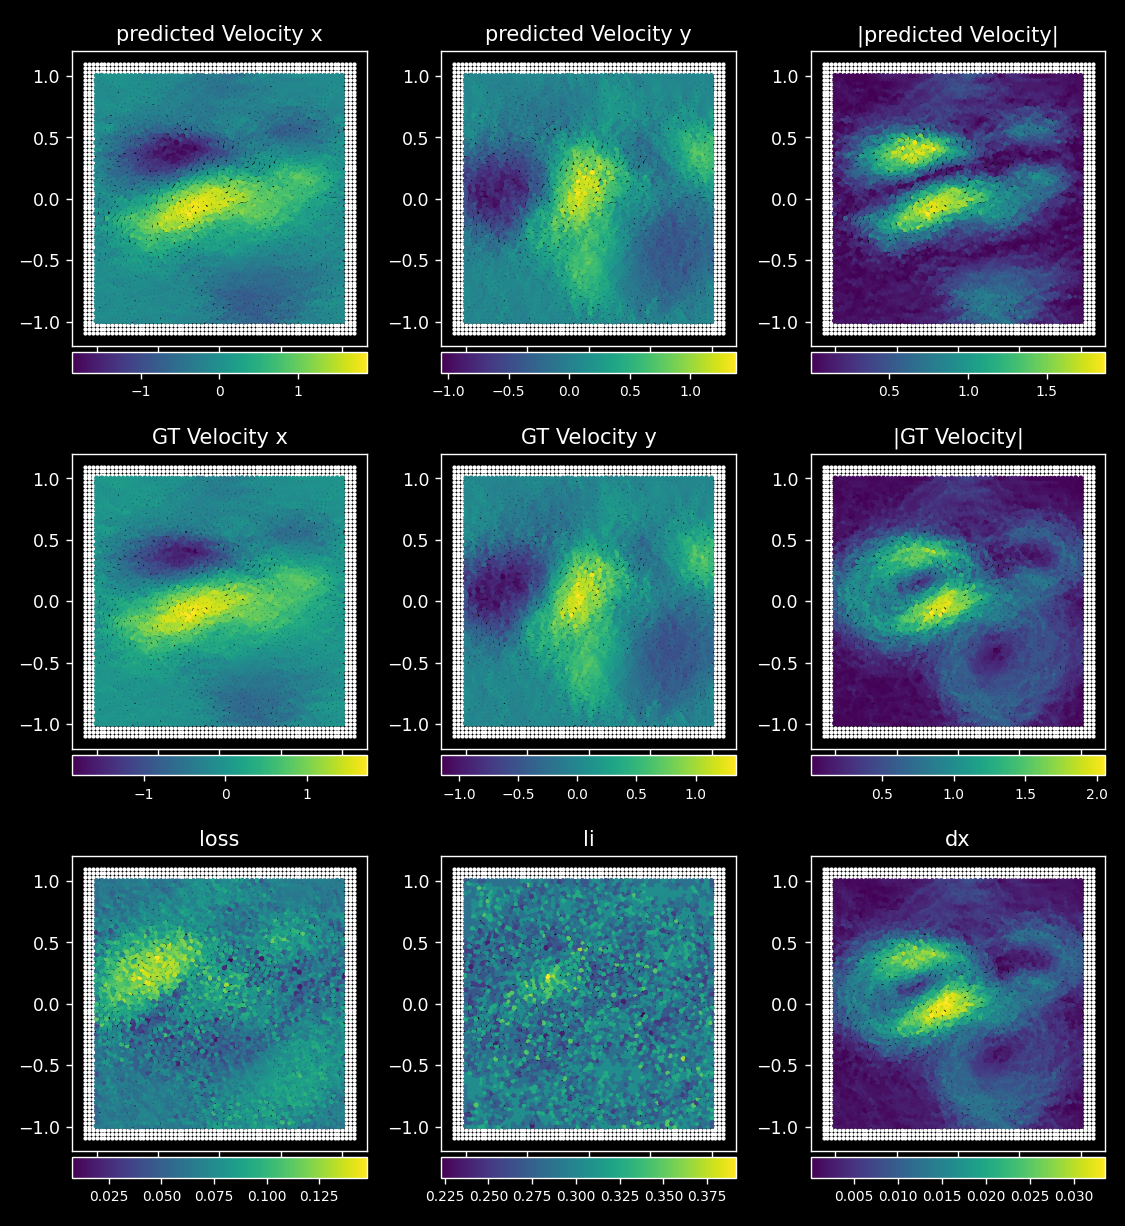

/home/winchenbach/anaconda3/envs/torch_env/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:11: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(IntSlider(value=1, description='x', max=32, min=1), Output()), _dom_classes=('widget-int…

In [21]:
def scatterPlot(axis, positions, data, boundaryPositions = None, title = 'untitled'):
    x = positions[:,0].detach().cpu().numpy()
    y = positions[:,1].detach().cpu().numpy()
    v = data.detach().cpu().numpy()
    
    axis.set_title(title)
    axis.axis('equal')
    axis.set_xlim(-1.2,1.2)
    axis.set_ylim(-1.2,1.2)
    if boundaryPositions is not None:
        axis.scatter(boundaryPositions[:,0].detach().cpu().numpy(), boundaryPositions[:,1].detach().cpu().numpy(), c = 'white', s =2 )
    sc = axis.scatter(x,y,c = v, s = 4)
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='horizontal')
    cbar.ax.tick_params(labelsize=8) 
    return sc, cbar
def update(positions, data, sc, cbar):
    sc.set_offsets(positions)
    sc.set_array(data)
    cbar.mappable.set_clim(vmin = np.min(data), vmax = np.max(data))    
def plotStep(index, positions, features, lis, losses, groundTruths):
    update(positions[index].detach().cpu().numpy(), features[index][:,1].detach().cpu().numpy(), scPredX, cbarPredX)
    update(positions[index].detach().cpu().numpy(), features[index][:,2].detach().cpu().numpy(), scPredY, cbarPredY)
    update(positions[index].detach().cpu().numpy(), torch.linalg.norm(features[index][:,1:2], axis = 1).detach().cpu().numpy(), scPredN, cbarPredN)
    
    update(groundTruths[index - 1][:,:2].detach().cpu().numpy(), groundTruths[index - 1][:,2].detach().cpu().numpy(), scGTX, cbarGTX)
    update(groundTruths[index - 1][:,:2].detach().cpu().numpy(), groundTruths[index - 1][:,3].detach().cpu().numpy(), scGTY, cbarGTY)
    update(groundTruths[index - 1][:,:2].detach().cpu().numpy(), torch.linalg.norm(groundTruths[index - 1][:,2:4], axis = 1).detach().cpu().numpy(), scGTN, cbarGTN)
    
    update(groundTruths[index - 1][:,:2].detach().cpu().numpy(), losses[index].detach().cpu().numpy(), scL, cbarL)
    update(groundTruths[index - 1][:,:2].detach().cpu().numpy(), lis[index].detach().cpu().numpy(), scli, cbarli)
    update(groundTruths[index - 1][:,:2].detach().cpu().numpy(), torch.linalg.norm(positions[index] - positions[index - 1], axis = 1).detach().cpu().numpy(), scdx, cbardx)

    fig.canvas.draw()
    fig.canvas.flush_events()
    
    
    
fig, axis = plt.subplots(3, 3, figsize=(9,9*1.09), sharex = False, sharey = False, squeeze = False)
scPredX, cbarPredX = scatterPlot(axis[0,0], positions[-1], features[-1][:,1], boundaryPositions = inputBoundaryPositions, title = 'predicted Velocity x')
scPredY, cbarPredY = scatterPlot(axis[0,1], positions[-1], features[-1][:,2], boundaryPositions = inputBoundaryPositions, title = 'predicted Velocity y')
scPredN, cbarPredN = scatterPlot(axis[0,2], positions[-1], torch.linalg.norm(features[-1][:,1:3], axis = 1), boundaryPositions = inputBoundaryPositions, title = '|predicted Velocity|')

scGTX, cbarGTX = scatterPlot(axis[1,0], groundTruths[-1][:,:2], groundTruths[-1][:,2], boundaryPositions = inputBoundaryPositions, title = 'GT Velocity x')
scGTY, cbarGTY = scatterPlot(axis[1,1], groundTruths[-1][:,:2], groundTruths[-1][:,3], boundaryPositions = inputBoundaryPositions, title = 'GT Velocity y')
scGTN, cbarGTN = scatterPlot(axis[1,2], groundTruths[-1][:,:2], torch.linalg.norm(groundTruths[-1][:,2:4], axis = 1), boundaryPositions = inputBoundaryPositions, title = '|GT Velocity|')

scL, cbarL = scatterPlot(axis[2,0], groundTruths[-1][:,:2], losses[-1], boundaryPositions = inputBoundaryPositions, title = 'loss')
scli, cbarli = scatterPlot(axis[2,1], groundTruths[-1][:,:2], lis[-1], boundaryPositions = inputBoundaryPositions, title = 'li')
scdx, cbardx = scatterPlot(axis[2,2], groundTruths[-1][:,:2], torch.linalg.norm(positions[-1] - positions[-2], axis = 1), boundaryPositions = inputBoundaryPositions, title = 'dx')

fig.tight_layout()
plotStep(1, positions, features, lis, losses, groundTruths)
inter = interact(lambda x: plotStep(x, positions, features, lis, losses, groundTruths), x = widgets.IntSlider(value=1, min=1, max=unrollSteps, step=1))

In [22]:
lossDatas = []

boundaryPos = inputBoundaryPositions.to(device)
flArea = inputData['fluidArea'].to(device)
bdyArea = inputData['boundaryArea'].to(device)

for i in tqdm(range(unrollSteps)):
    lossData = getLossData(positions[i + 1].detach(), groundTruths[i][:,:2].detach(), boundaryPos.detach(), features[i+1][:,1:3].detach(), groundTruths[i][:,2:4].detach(), flArea.detach(), bdyArea.detach(), attributes)
    lossDatas.append(lossData)

  0%|          | 0/32 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


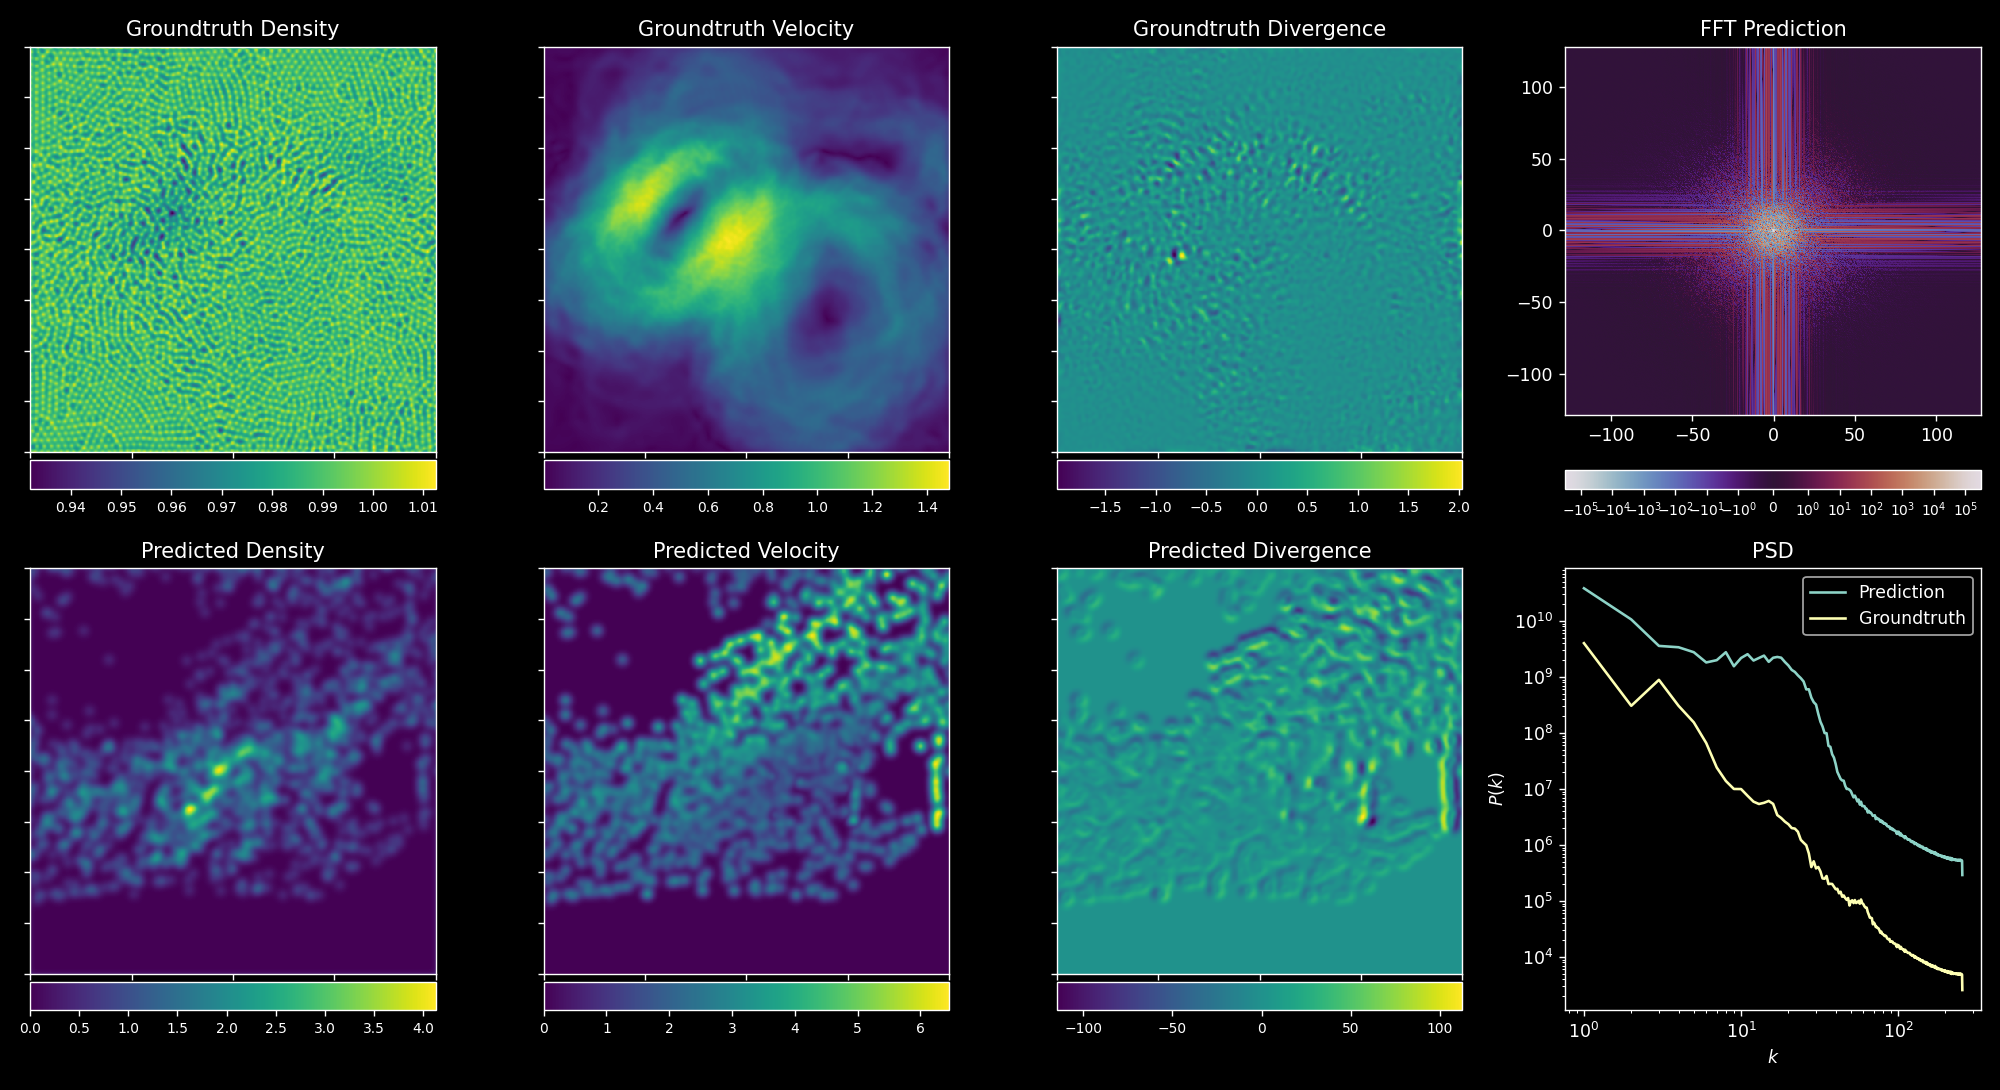

In [23]:
def plotLoss(lossData):
    fig, axis = plt.subplots(2, 4, figsize=(16,8*1.09), sharex = False, sharey = False, squeeze = False)

    imPredDensity, cbarPredDensity = meshPlot(axis[1,0], lossData['mesh'], lossData['predMeshDensity'], 'Predicted Density')
    scDensity, cbarDensity = meshPlot(axis[0,0], lossData['mesh'], lossData['gtMeshDensity'], 'Groundtruth Density')
    imPredVelocity, cbarPredVelocity = meshPlot(axis[1,1], lossData['mesh'], np.linalg.norm(lossData['predMeshVelocity'], axis = -1), 'Predicted Velocity')
    scVelocity, cbarvelocity = meshPlot(axis[0,1], lossData['mesh'], np.linalg.norm(lossData['gtMeshVelocity'], axis = -1), 'Groundtruth Velocity')
    imPredDivergence, cbarPredDivergence = meshPlot(axis[1,2], lossData['mesh'], lossData['predMeshDivergence'], 'Predicted Divergence')
    scColor, cbarColor = meshPlot(axis[0,2], lossData['mesh'], lossData['gtMeshDivergence'], 'Groundtruth Divergence')
    ax = axis[0,3]
    ax.set_title('FFT Prediction')
    imPredFFT = ax.pcolormesh(lossData['frequencies'][0], lossData['frequencies'][1], lossData['predFFT'],
                      norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-np.max(lossData['predFFT']), vmax=np.max(lossData['predFFT']), base=10), cmap = 'twilight')    
    ax1_divider = make_axes_locatable(ax)
    cax1 = ax1_divider.append_axes("bottom", size="5%", pad="15%")
    cbarPredFFT = fig.colorbar(imPredFFT, cax=cax1,orientation='horizontal')
    cbarPredFFT.ax.tick_params(labelsize=8) 
    axis[1,3].set_title('PSD')
    kvals, Abins = lossData['predPSD']
    _, gtAbins = lossData['gtPSD']
    axis[1,3].loglog(kvals, Abins, label = 'Prediction')
    axis[1,3].loglog(kvals, gtAbins, label = 'Groundtruth')
    axis[1,3].set_xlabel("$k$")
    axis[1,3].set_ylabel("$P(k)$")
    axis[1,3].legend()
    fig.tight_layout()

    
plotLoss(lossDatas[-1])

In [24]:
cm = mpl.colormaps['viridis']

In [25]:
def getQuantities(data):
    mi = np.min(data)
    ma = np.max(data)
    med = np.median(data)
    stddev = np.std(data)
    q_01 = np.percentile(data, 1)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    q_99 = np.percentile(data, 99)
    
    return mi, ma, med, stddev, q_01, q1, q3, q_99

<IPython.core.display.Javascript object>


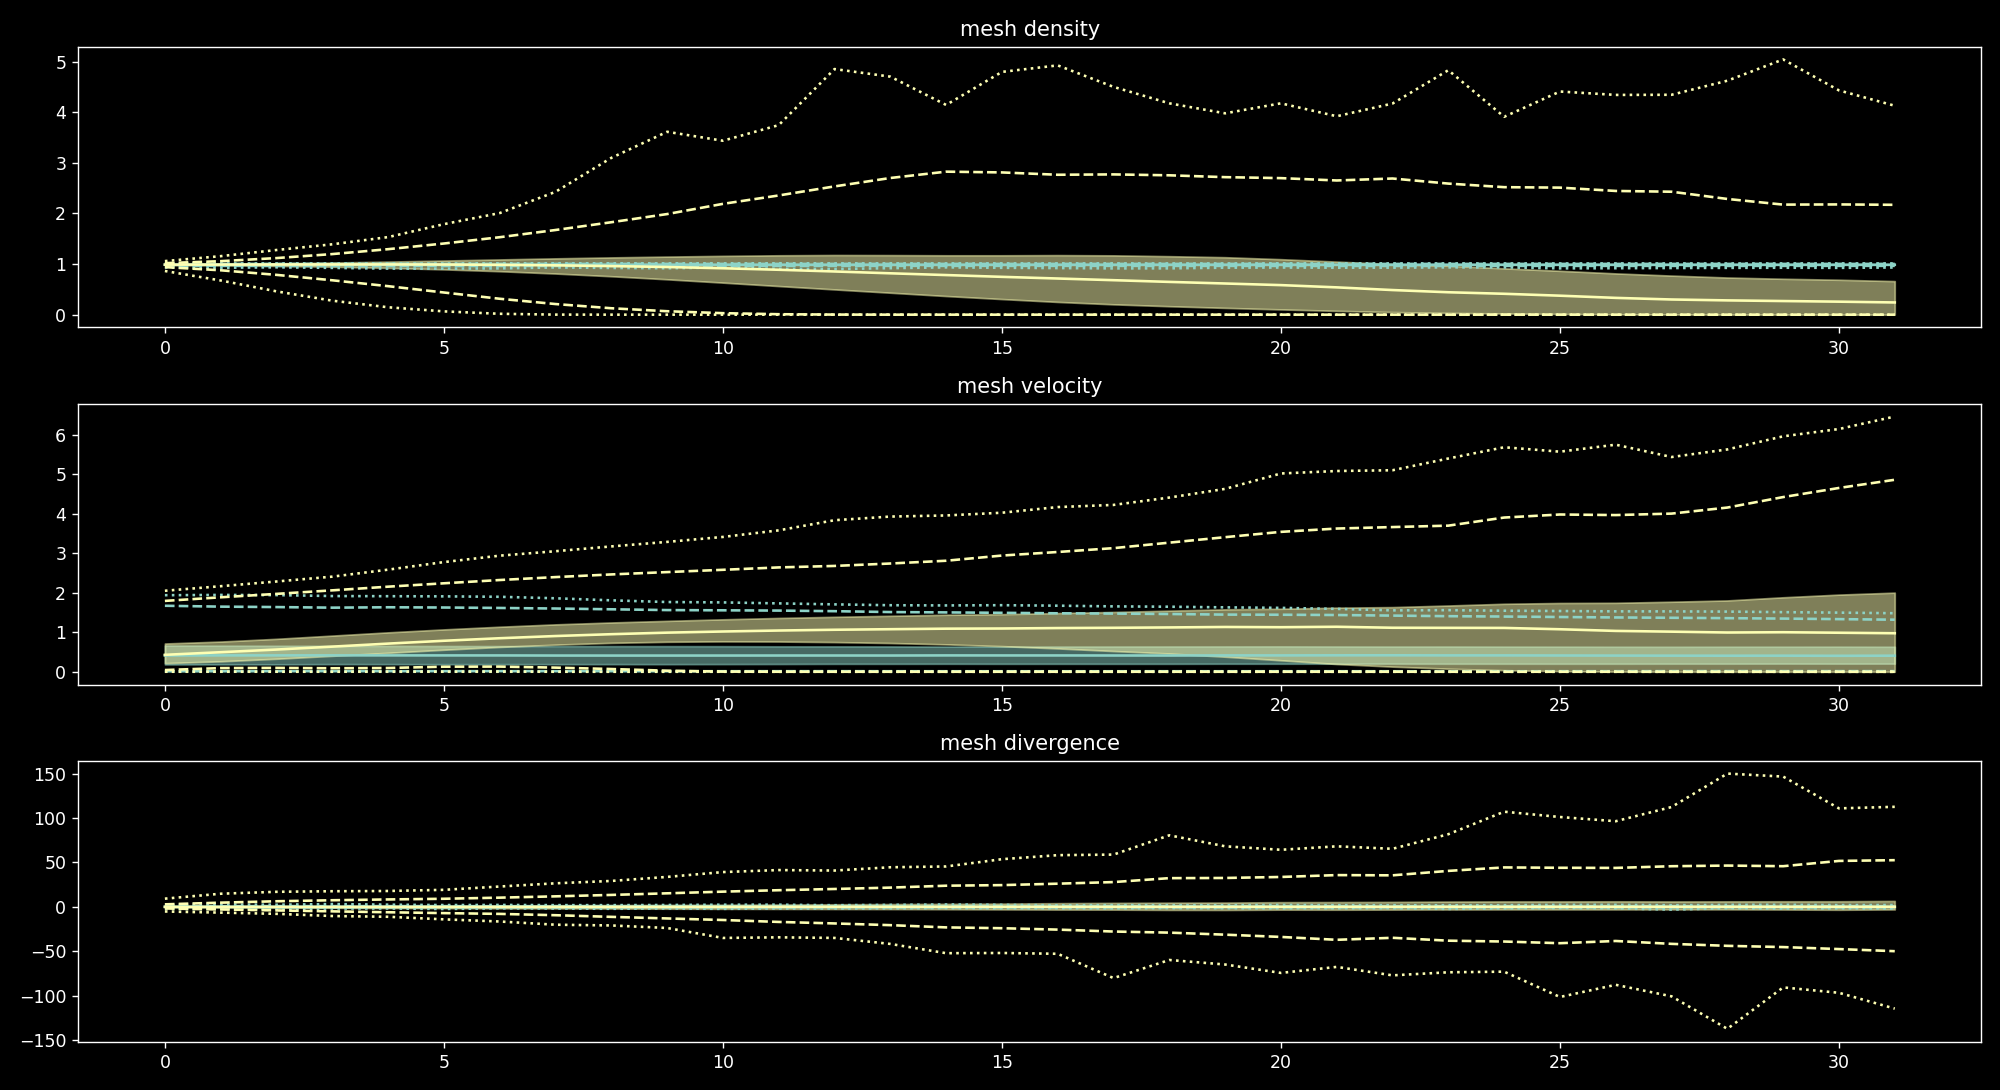

In [26]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# data = np.vstack([np.hstack(getQuantities(l['gtMeshDensity'])) for l in lossDatas])

fig, axis = plt.subplots(3, 1, figsize=(16,8*1.09), sharex = False, sharey = False, squeeze = False)

def plotData(axis, col, data, l = '/'):
    axis.plot(data[:,2], c = col, label = l)
    axis.fill_between(np.arange(data.shape[0]), data[:,5], data[:,6], color = col, alpha = 0.5)
    axis.plot(data[:,0], ls = ':', c = col)
    axis.plot(data[:,1], ls = ':', c = col)
    axis.plot(data[:,4], ls = '--', c = col)
    axis.plot(data[:,7], ls = '--', c = col)
    
axis[0,0].set_title('mesh density')
plotData(axis[0,0], cols[0], np.vstack([np.hstack(getQuantities(l['gtMeshDensity'])) for l in lossDatas]), 'gt')
plotData(axis[0,0], cols[1], np.vstack([np.hstack(getQuantities(l['predMeshDensity'])) for l in lossDatas]), 'pred')

axis[1,0].set_title('mesh velocity')
plotData(axis[1,0], cols[0], np.vstack([np.hstack(getQuantities(np.linalg.norm(l['gtMeshVelocity'],axis=-1))) for l in lossDatas]), 'gt')
plotData(axis[1,0], cols[1], np.vstack([np.hstack(getQuantities(np.linalg.norm(l['predMeshVelocity'],axis=-1))) for l in lossDatas]), 'pred')

axis[2,0].set_title('mesh divergence')
plotData(axis[2,0], cols[0], np.vstack([np.hstack(getQuantities(l['gtMeshDivergence'])) for l in lossDatas]), 'gt')
plotData(axis[2,0], cols[1], np.vstack([np.hstack(getQuantities(l['predMeshDivergence'])) for l in lossDatas]), 'pred')

fig.tight_layout()

<IPython.core.display.Javascript object>


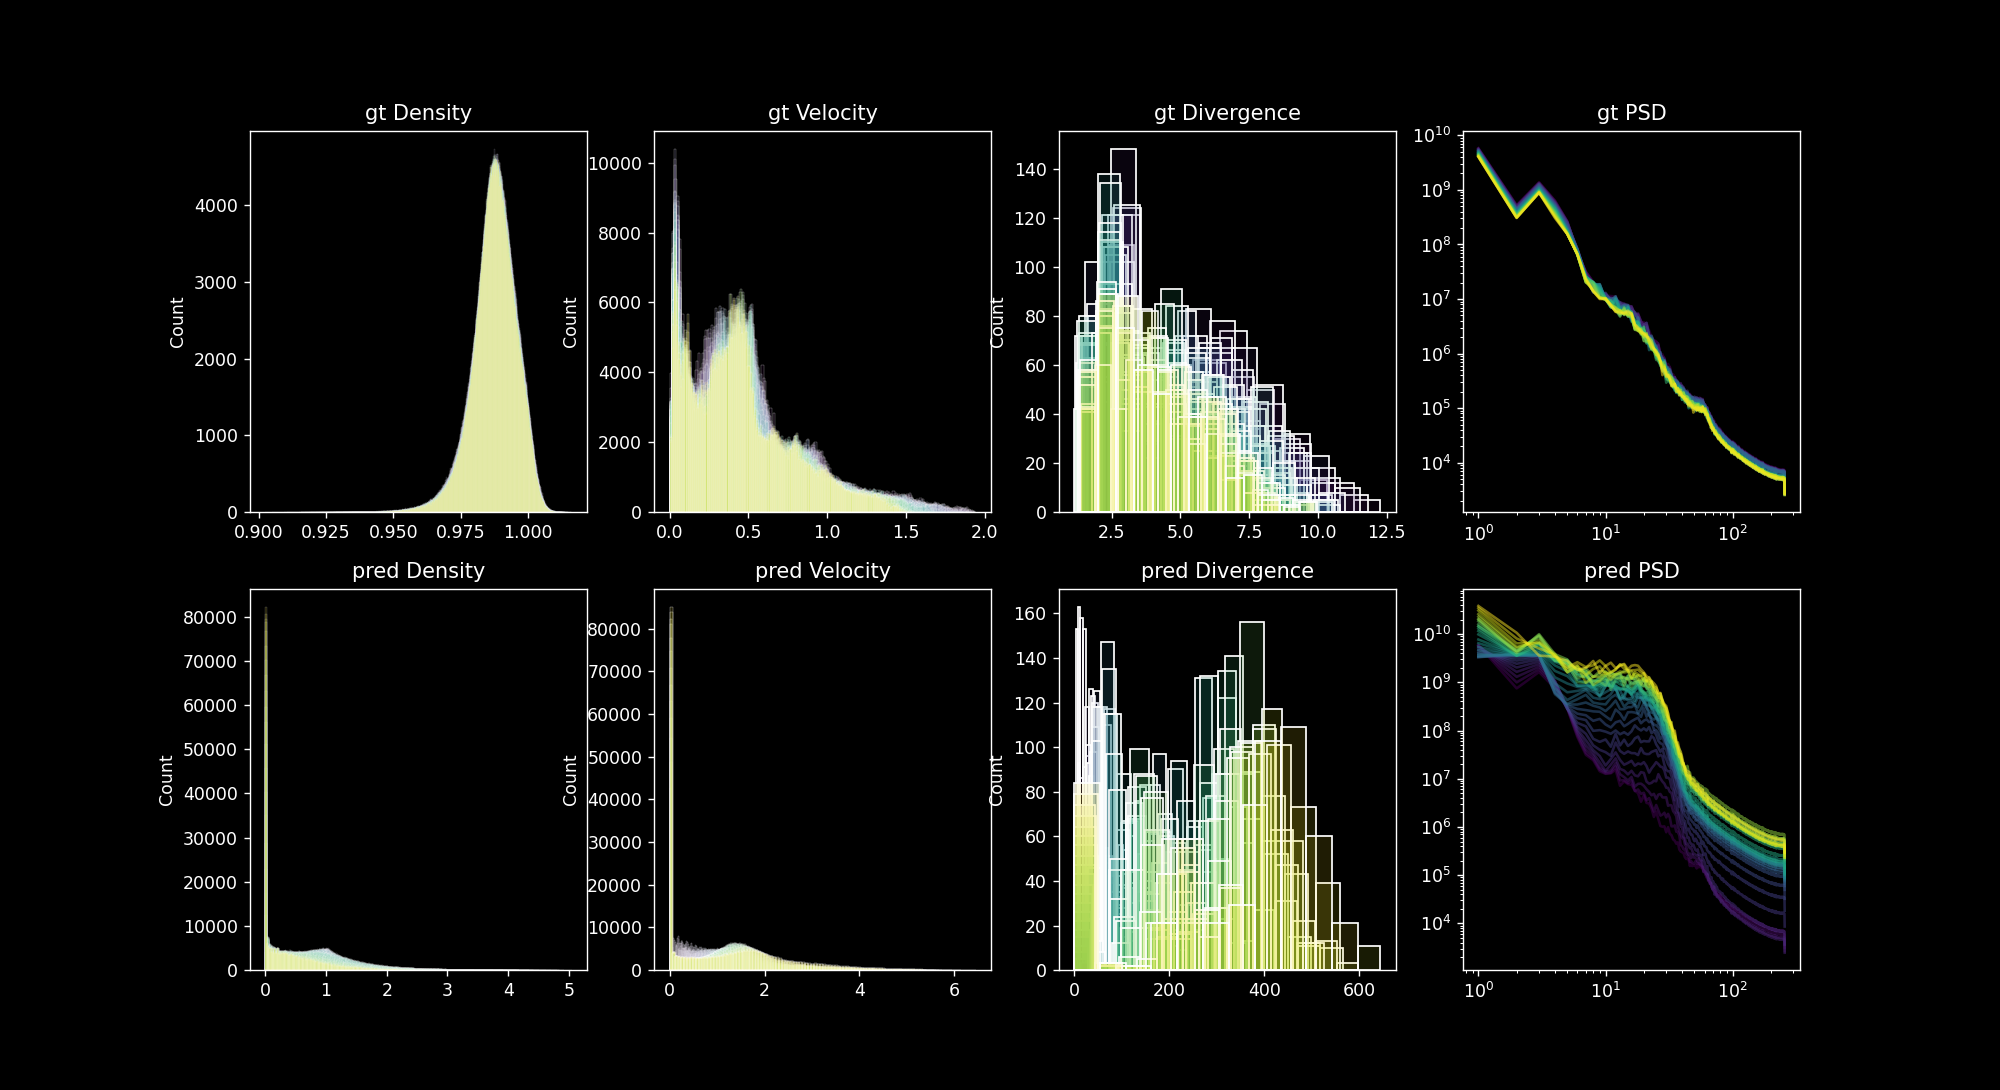

  0%|          | 0/32 [00:00<?, ?it/s]

In [27]:
fig, axis = plt.subplots(2, 4, figsize=(16,8*1.09), sharex = False, sharey = False, squeeze = False)

for i, l in enumerate(tqdm(lossDatas)):
#     sns.kdeplot(l['gtMeshDensity'].flatten(), bw_adjust = 1, ax = axis[0,0], c = cm(i / (len(lossDatas) - 1)))
    sns.histplot(l['gtMeshDensity'].flatten(), ax = axis[0,0], color = cm(i / (len(lossDatas) - 1)), alpha = 0.125)
    axis[0,0].set_title('gt Density')
    sns.histplot(np.linalg.norm(l['gtMeshVelocity'],axis=-1).flatten(), ax = axis[0,1], color = cm(i / (len(lossDatas) - 1)), alpha = 0.125)
    axis[0,1].set_title('gt Velocity')
    sns.histplot(np.linalg.norm(l['gtMeshDivergence'],axis=-1).flatten(), ax = axis[0,2], color = cm(i / (len(lossDatas) - 1)), alpha = 0.125)
    axis[0,2].set_title('gt Divergence')
    kvals, gtAbins = l['gtPSD']
    axis[0,3].loglog(kvals, gtAbins, color = cm(i / (len(lossDatas) - 1)), alpha = 0.5 )
    axis[0,3].set_title('gt PSD')
    
    sns.histplot(l['predMeshDensity'].flatten(), ax = axis[1,0], color = cm(i / (len(lossDatas) - 1)), alpha = 0.125)
    axis[1,0].set_title('pred Density')
    sns.histplot(np.linalg.norm(l['predMeshVelocity'],axis=-1).flatten(), ax = axis[1,1], color = cm(i / (len(lossDatas) - 1)), alpha = 0.125)
    axis[1,1].set_title('pred Velocity')
    sns.histplot(np.linalg.norm(l['predMeshDivergence'],axis=-1).flatten(), ax = axis[1,2], color = cm(i / (len(lossDatas) - 1)), alpha = 0.125)
    axis[1,2].set_title('pred Divergence')
    kvals, gtAbins = l['predPSD']
    axis[1,3].loglog(kvals, gtAbins, color = cm(i / (len(lossDatas) - 1)), alpha = 0.5 )
    axis[1,3].set_title('pred PSD')
#     break


In [28]:

def getPSD(data):
    image = data.detach().cpu().numpy()
    npix = image.shape[0]
    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)**2
    kfreq = np.fft.fftfreq(npix) * npix

    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()
    kbins = np.arange(0.01, npix//(2*np.pi)+1, 0.5)
    kbins = np.arange(0.5, npix//2+1, 1.)

    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                         statistic = "mean",
                                         bins = kbins)

    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return kvals, Abins


kVals, psd0 = getPSD(torch.tensor(np.linalg.norm(lossDatas[0]['gtMeshVelocity'], axis = -1)))
_, psd1 = getPSD(torch.tensor(np.linalg.norm(lossDatas[-1]['gtMeshVelocity'], axis = -1)))

print(psd1 - psd0)

[-1.81618150e+09 -2.20246455e+08 -4.92596919e+08 -3.32746895e+08
 -1.11835403e+08 -5.52228796e+06 -7.37901165e+06 -6.94119307e+06
 -4.17085476e+06 -1.71813573e+06 -3.79658657e+06 -5.19363147e+06
 -1.49614920e+06 -2.29086299e+06 -1.08064694e+05 -1.45128079e+06
 -1.69208361e+06 -1.93643808e+06 -1.18197197e+06 -1.40539154e+06
 -1.38725613e+06 -6.85693331e+05 -2.92057140e+05 -5.24935132e+05
 -5.89287631e+05 -4.94090197e+05 -1.51583029e+05 -5.68755739e+05
 -2.71819563e+05 -2.34115679e+05 -2.44393017e+05 -2.28057292e+05
 -1.73879757e+05 -1.65275762e+05 -9.01579275e+04 -1.24329518e+05
 -9.46975131e+04 -7.09588319e+04 -6.61608832e+04 -8.12095486e+04
 -7.71761459e+04 -5.77992524e+04 -4.84163229e+04 -7.23753646e+04
 -6.33413653e+04 -4.55155958e+04 -6.51289718e+04 -3.13842101e+04
 -6.54576668e+04 -4.13354395e+04 -3.40906741e+04 -4.18081646e+04
 -4.73844620e+04 -4.20146939e+04 -6.14775929e+04 -4.35577506e+04
 -5.04988178e+04 -4.23124604e+04 -2.92221126e+04 -2.86842435e+04
 -3.49524960e+04 -1.86647

In [31]:
# Setup
model, optimizer, hyperParameterDict, lr = buildNetwork(args)

unrollSteps = 32

optimizer.zero_grad()

inputFluidPositions, inputBoundaryPositions, inputFluidFeatures, inputBoundaryFeatures, groundTruths = prepareData(attributes, inputData, groundTruthData, device)

def doStep(inputFluidPositions, inputFluidFeatures, unrollSteps, train = True):    
    positions = [inputFluidPositions]
    features = [inputFluidFeatures]
    lis = []
    losses = []
    if train:
        optimizer.zero_grad()
        
    for i in (t := tqdm(range(unrollSteps), leave = False)):
        loss, predictedPositions, predictedVelocity = runNetwork(positions[-1], features[-1][:,1:3], attributes, args.frameDistance, gravity, features[-1], inputBoundaryPositions, inputBoundaryFeatures, groundTruths[i], model, None, None, False)
        positions.append(predictedPositions)
        f = torch.hstack((features[-1][:,0][:,None], predictedVelocity, features[-1][:,3:]))
        features.append(f)
        lis.append(model.li)
        losses.append(loss)
        t.set_description('[%2d] Loss: %g [%g - %g] +- %g' % (i, torch.mean(loss).detach().cpu().numpy(), torch.min(loss).detach().cpu().numpy(), torch.max(loss).detach().cpu().numpy(), torch.std(loss).detach().cpu().numpy()))
        
    if train:
        meanLoss = torch.mean(torch.vstack(losses))
        meanLoss.backward()
        optimizer.step()

    return torch.vstack(losses).detach().cpu()

Building Network
Number of parameters 181414


In [ ]:
ls = []
for epoch in tqdm(range(32)):
    for i in (ti := tqdm(range(100), leave = False)):
        losses = doStep(inputFluidPositions, inputFluidFeatures, max(1,epoch))
        ls.append(losses)
        ti.set_description('%6g - %6g' % (torch.mean(torch.vstack(ls)).detach().cpu(), torch.mean(losses.detach().cpu())))
    if epoch % 2 == 0 and epoch > 0:
        lr = lr * 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


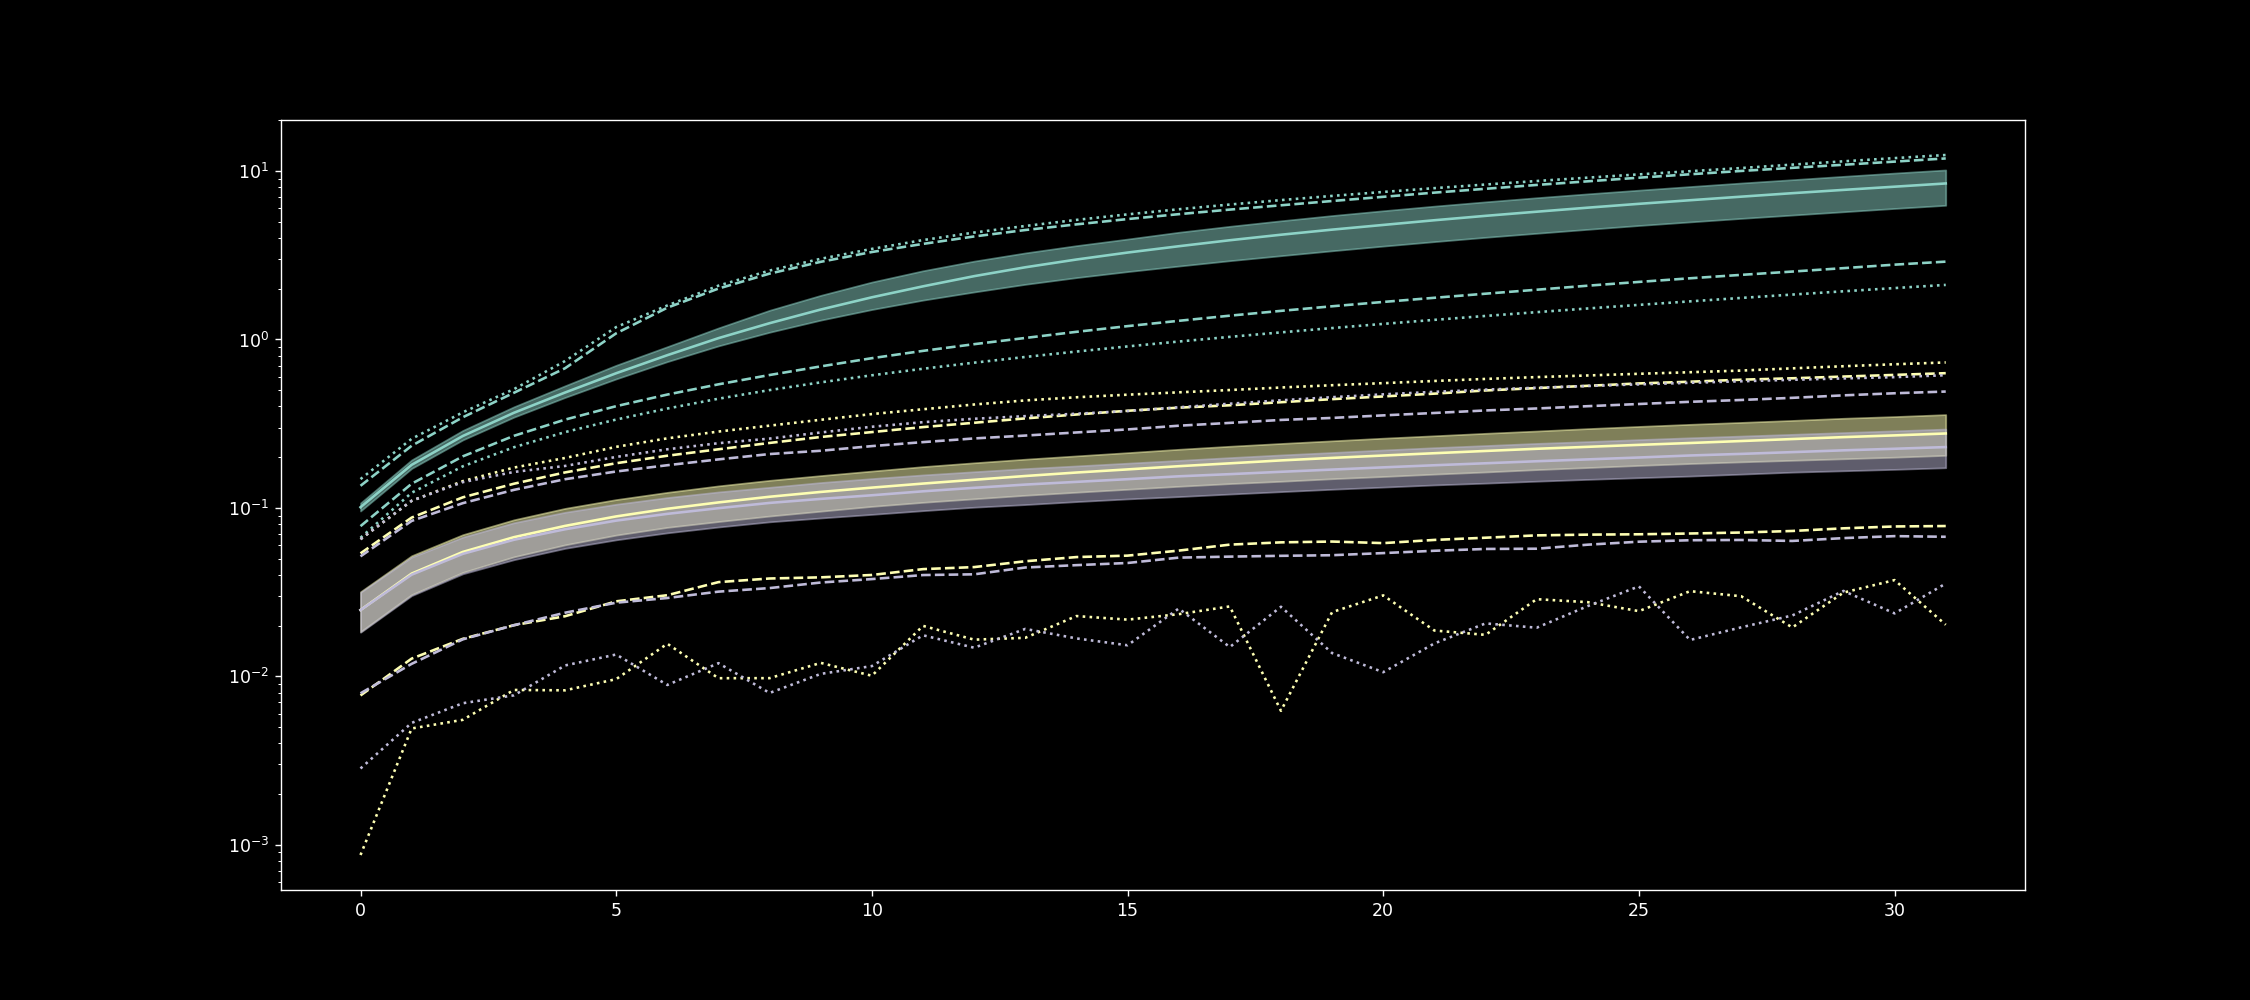

In [79]:
fig, axis = plt.subplots(1, 1, figsize=(18,8), sharex = False, sharey = False, squeeze = False)

def getQuantitiesLoss(data):
    cpuData = data.detach().cpu().numpy()
    mi = torch.min(data, dim = 1)[0].detach().cpu().numpy()
    ma = torch.max(data, dim = 1)[0].detach().cpu().numpy()
    med = torch.median(data, dim = 1)[0].detach().cpu().numpy()
    stddev = torch.std(data, dim = 1).detach().cpu().numpy()
    q_01 = np.percentile(cpuData, 1, axis = 1)
    q1 = np.percentile(cpuData, 25, axis = 1)
    q3 = np.percentile(cpuData, 75, axis = 1)
    q_99 = np.percentile(cpuData, 99, axis = 1)
    
    return mi, ma, med, stddev, q_01, q1, q3, q_99
q = np.vstack(getQuantitiesLoss(losses)).transpose()

# print(q)
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

plotData(axis[0,0], cols[0], np.vstack(getQuantitiesLoss(ls[0])).transpose())
plotData(axis[0,0], cols[1], np.vstack(getQuantitiesLoss(ls[len(ls)//2])).transpose())
plotData(axis[0,0], cols[2], np.vstack(getQuantitiesLoss(ls[-1])).transpose())
axis[0,0].set_yscale('log')
# def plotData(axis, col, data, l = '/'):

# axis[0,0].semilogy(torch.mean(torch.vstack(losses), dim = 1).detach().cpu().numpy())
# axis[0,0].semilogy(torch.min(torch.vstack(losses), dim = 1)[0].detach().cpu().numpy())
# axis[0,0].semilogy(torch.max(torch.vstack(losses), dim = 1)[0].detach().cpu().numpy())

  0%|          | 0/32 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


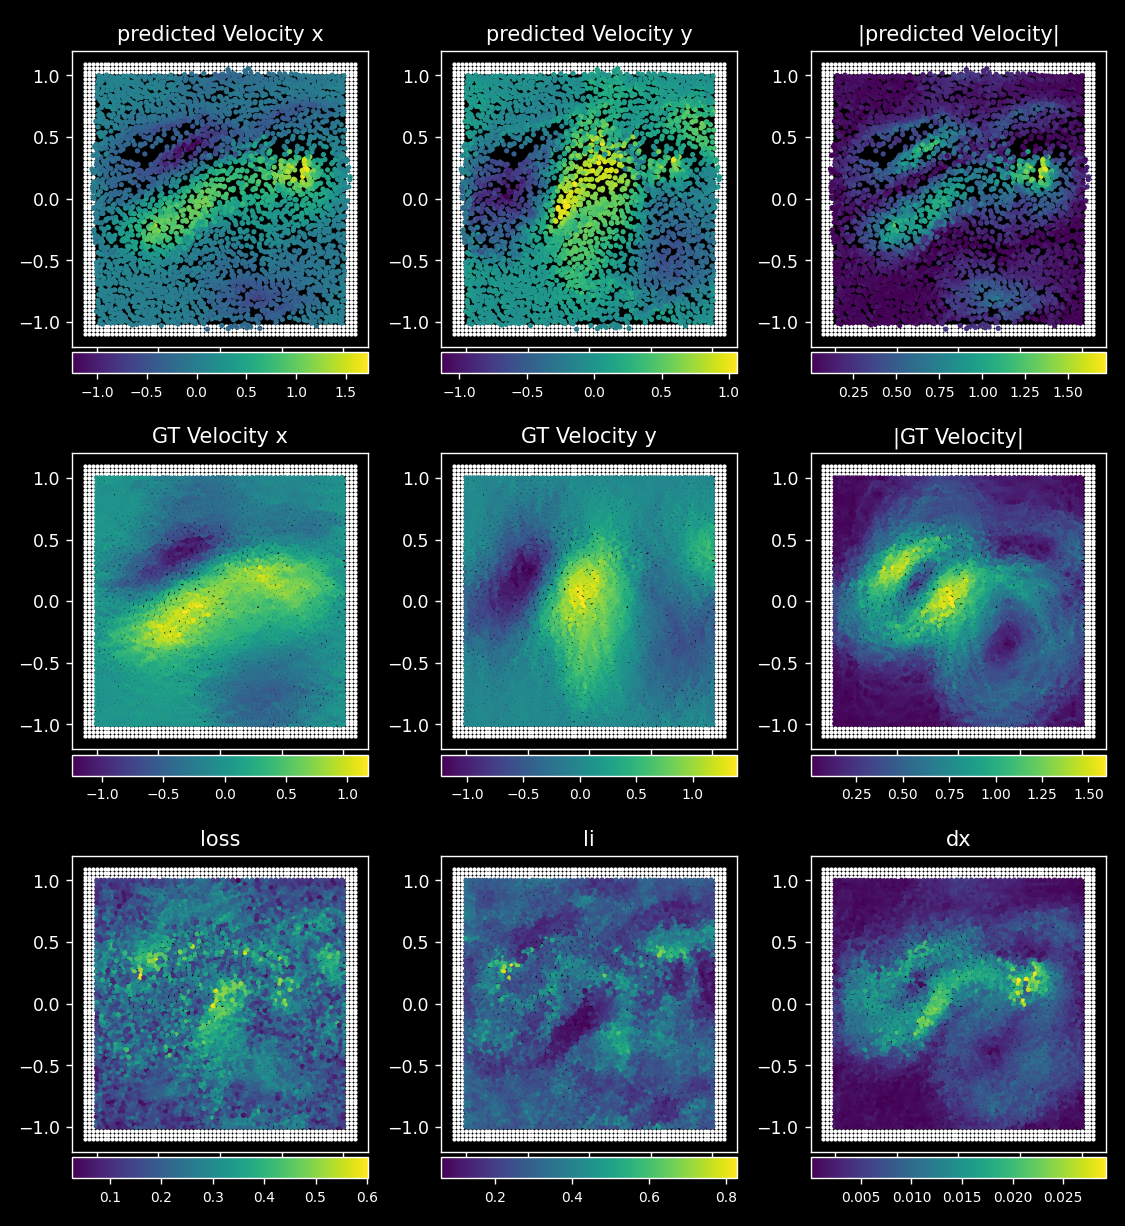

interactive(children=(IntSlider(value=1, description='x', max=32, min=1), Output()), _dom_classes=('widget-int…

In [80]:

unrollSteps = 32

optimizer.zero_grad()

positions = [inputFluidPositions]
features = [inputFluidFeatures]
lis = []
losses = []

for i in tqdm(range(unrollSteps)):
    loss, predictedPositions, predictedVelocity = runNetwork(positions[-1], features[-1][:,1:3], attributes, args.frameDistance, gravity, features[-1], inputBoundaryPositions, inputBoundaryFeatures, groundTruths[i], model, None, None, False)
    positions.append(predictedPositions)
    f = torch.hstack((features[-1][:,0][:,None], predictedVelocity, features[-1][:,3:]))
    features.append(f)
    lis.append(model.li)
    losses.append(loss)
#     break
    
    
fig, axis = plt.subplots(3, 3, figsize=(9,9*1.09), sharex = False, sharey = False, squeeze = False)
scPredX, cbarPredX = scatterPlot(axis[0,0], positions[-1], features[-1][:,1], boundaryPositions = inputBoundaryPositions, title = 'predicted Velocity x')
scPredY, cbarPredY = scatterPlot(axis[0,1], positions[-1], features[-1][:,2], boundaryPositions = inputBoundaryPositions, title = 'predicted Velocity y')
scPredN, cbarPredN = scatterPlot(axis[0,2], positions[-1], torch.linalg.norm(features[-1][:,1:3], axis = 1), boundaryPositions = inputBoundaryPositions, title = '|predicted Velocity|')

scGTX, cbarGTX = scatterPlot(axis[1,0], groundTruths[-1][:,:2], groundTruths[-1][:,2], boundaryPositions = inputBoundaryPositions, title = 'GT Velocity x')
scGTY, cbarGTY = scatterPlot(axis[1,1], groundTruths[-1][:,:2], groundTruths[-1][:,3], boundaryPositions = inputBoundaryPositions, title = 'GT Velocity y')
scGTN, cbarGTN = scatterPlot(axis[1,2], groundTruths[-1][:,:2], torch.linalg.norm(groundTruths[-1][:,2:4], axis = 1), boundaryPositions = inputBoundaryPositions, title = '|GT Velocity|')

scL, cbarL = scatterPlot(axis[2,0], groundTruths[-1][:,:2], losses[-1], boundaryPositions = inputBoundaryPositions, title = 'loss')
scli, cbarli = scatterPlot(axis[2,1], groundTruths[-1][:,:2], lis[-1], boundaryPositions = inputBoundaryPositions, title = 'li')
scdx, cbardx = scatterPlot(axis[2,2], groundTruths[-1][:,:2], torch.linalg.norm(positions[-1] - positions[-2], axis = 1), boundaryPositions = inputBoundaryPositions, title = 'dx')

fig.tight_layout()
plotStep(1, positions, features, lis, losses, groundTruths)
inter = interact(lambda x: plotStep(x, positions, features, lis, losses, groundTruths), x = widgets.IntSlider(value=1, min=1, max=unrollSteps, step=1))

In [ ]:

def processDataLoaderIter(iterations, e, rollout, ds, dataLoader, dataIter, model, optimizer, train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01):
    with record_function("prcess data loader"): 
        losses = []
        batchIndices = []

        if train:
            model.train(True)
        else:
            model.train(False)

        i = 0
        for b in (pbl := tqdm(range(iterations), leave=False)):
            try:
                bdata = next(dataIter)
            except:
                dataIter = iter(dataLoader)
                bdata = next(dataIter)
                
            with record_function("prcess data loader[batch]"): 
                if train:
                    optimizer.zero_grad()
                batchLosses, meanLosses, minLosses, maxLosses, stdLosses = processBatch(model, device, True, e, rollout, ds, bdata, frameDistance, augmentAngle, augmentJitter, jitterAmount, adjustForFrameDistance = args.adjustForFrameDistance)
                # print(torch.max(model.ni))
                
                batchIndices.append(np.array(bdata))
                losses.append(batchLosses.detach().cpu().numpy())

                with record_function("prcess data loader[batch] - backward"): 
                    sumLosses = torch.mean(batchLosses[:,:,0]) #+ torch.mean(batchLosses[:,:,1])
                    if train:
                        sumLosses.backward()
                        optimizer.step()
                lossString = np.array2string(torch.mean(batchLosses[:,:,0],dim=0).detach().cpu().numpy(), formatter={'float_kind':lambda x: "%.2e" % x})
                batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%04d' % x}))

#                 with portalocker.Lock('README.md', flags = 0x2, timeout = None):
                pbl.set_description('%8s[gpu %d]: %3d [%1d] @ %1.1e: :  %s -> %.2e' %(prefix, args.gpu, e, rollout, lr, batchString, sumLosses.detach().cpu().numpy()))
                pbl.update()
                if prefix == 'training':
                    # pb.set_description('[gpu %d] Learning: %1.4e Validation: %1.4e' %(args.gpu, np.mean(np.mean(np.vstack(losses)[:,:,0], axis = 1)), 0))
                    pb.set_description('[gpu %d] %90s - Learning: %1.4e' %(args.gpu, shortLabel, np.mean(np.mean(np.vstack(losses)[:,:,0], axis = 1))))
                if prefix == 'validation':
                    pb.set_description('[gpu %d] Learning: %1.4e Validation: %1.4e' %(args.gpu, trainLoss, np.mean(np.mean(np.vstack(losses)[:,:,0], axis = 1))))
                pb.update()
#                 i = i + 1
#                 if i > 100:
#                     break
        bIndices  = np.hstack(batchIndices)
        losses = np.vstack(losses)

        # idx = np.argsort(bIndices)
        # bIndices = bIndices[idx]
        # losses = losses[idx]

        epochLoss = losses
        return epochLoss

In [ ]:
training = {}
validation = {}
testing = {}

trainLoss = 0
validationLoss = 0
train_iter = iter(train_dataloader)

trainingEpochLosses = []
trainingEpochLosses2 = []
validationLosses = []

unroll = 2

random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
# if args.verbose:
    # print('Start of training')

pb = tqdm(range(epochs * args.iterations))
# pb.reset(total=len(train_dataloader))
for epoch in range(epochs):
    losses = []

    unroll = max(args.minUnroll, min(epoch // 2 + 1, args.maxUnroll))
    # trainingEpochLoss = processDataLoaderIter(args.iterations, epoch, epoch // 2 + 1, train_ds, train_dataloader, train_iter, model, optimizer, True, prefix = 'training', augmentAngle=args.argumentAngle, augmentJitter=args.augmentJitter, jitterAmount=args.jitterAmount)
    trainingEpochLoss = processDataLoaderIter(args.iterations, epoch, unroll, train_ds, train_dataloader, train_iter, model, optimizer, True, prefix = 'training', augmentAngle=args.augmentAngle, augmentJitter=args.augmentJitter, jitterAmount=args.jitterAmount)

#     trainingEpochLoss = processDataLoader(epoch,unroll, train_ds, train_dataloader, model, optimizer, True, prefix = 'training')
    trainingEpochLosses.append(trainingEpochLoss)
    # torch.save(model.state_dict(), './trainingData/%s/model_%03d.torch' % (exportString, epoch))
    if epoch % 5 == 0 and epoch > 0:
        lr = lr * 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']
    torch.save(model.state_dict(), './trainingData/%s/model_%03d.torch' % (exportString, epoch))
